# Baseline model

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from hms.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, DropoutLayer
from hms.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError, L1Error
from hms.models import SingleLayerModel, MultipleLayerModel
from hms.initialisers import UniformInit, GlorotUniformInit, ConstantInit
from hms.learning_rules import GradientDescentLearningRule, AdamLearningRule
from hms.data_providers import HMS300dDataProvider
from hms.optimisers import Optimiser
from scipy.fftpack import fft, dct
from hms.penalties import L1Penalty, L2Penalty
import seaborn as sns;

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

## Helper functions to smooth prediction

In [79]:
def smooth_prediction(raw_prediction):
    output_shape = raw_prediction.shape
    # make a matrix that adds 20 lines paddings at the beginning & end of raw prediction
    calculation_frame = np.zeros((output_shape[0]+40, output_shape[1]))
    output = np.zeros(raw_prediction.shape)
    calculation_frame[20:-20, :] = raw_prediction
    
    for i in range(output_shape[0]):
        output[i,:] = calculation_frame[i+20,:] + \
        0.6 * (calculation_frame[i+21,:] + calculation_frame[i+19,:]) + \
        0.6 * (calculation_frame[i+22,:] + calculation_frame[i+18,:]) + \
        0.6 * (calculation_frame[i+23,:] + calculation_frame[i+17,:]) + \
        0.6 * (calculation_frame[i+24,:] + calculation_frame[i+16,:]) + \
        0.6 * (calculation_frame[i+25,:] + calculation_frame[i+15,:]) + \
        0.5 * (calculation_frame[i+26,:] + calculation_frame[i+14,:]) + \
        0.5 * (calculation_frame[i+27,:] + calculation_frame[i+13,:]) + \
        0.5 * (calculation_frame[i+28,:] + calculation_frame[i+12,:]) + \
        0.5 * (calculation_frame[i+29,:] + calculation_frame[i+11,:]) + \
        0.5 * (calculation_frame[i+30,:] + calculation_frame[i+10,:]) + \
        0.4 * (calculation_frame[i+31,:] + calculation_frame[i+9,:]) + \
        0.4 * (calculation_frame[i+32,:] + calculation_frame[i+8,:]) + \
        0.4 * (calculation_frame[i+33,:] + calculation_frame[i+7,:]) + \
        0.4 * (calculation_frame[i+34,:] + calculation_frame[i+6,:]) + \
        0.3 * (calculation_frame[i+35,:] + calculation_frame[i+5,:]) + \
        0.3 * (calculation_frame[i+36,:] + calculation_frame[i+4,:]) + \
        0.2 * (calculation_frame[i+37,:] + calculation_frame[i+3,:]) + \
        0.2 * (calculation_frame[i+38,:] + calculation_frame[i+2,:]) + \
        0.1 * (calculation_frame[i+39,:] + calculation_frame[i+1,:])
    output /= [6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
    return output

In [80]:
def fade_motion(motion, fading_point, window_size):
#     print("Motion length: {0}, Fading point: {1}".format(len(motion), fading_point))
    if fading_point < window_size:
        scaler = 0.9
        for i in range(fading_point, window_size):
            motion[i] *= scaler
            scaler *= scaler
    return motion

In [81]:
# Visualise fade_motion effects
# x = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# plt.plot(x)
# y = fade_motion(x, 5, len(x))
# plt.plot(y)
# plt.ylim([0, 1.3])

## Test different window sizes

In [89]:
window_size = 30
number_of_frequency = 10

train_data = HMS300dDataProvider('train', 'extro', '{}'.format(window_size), rng=rng)
valid_data = HMS300dDataProvider('validation', 'extro', '{}'.format(window_size), rng=rng)
input_dim, output_dim = 300, 120

In [90]:
train_data.inputs.shape

(22802, 300)

In [91]:
batch_size = 20  
init_scale = 0.01  
learning_rate = 0.001  
num_epochs = 50  
stats_interval = 1  
hidden_dim = 200

weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

weights_penalty_1 = L1Penalty(1e-1)
weights_penalty_2 = L2Penalty(1e-5)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

train_data.batch_size = batch_size 
valid_data.batch_size = batch_size


model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
#     ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
])

error = SumOfSquaredDiffsError()

learning_rule = AdamLearningRule(learning_rate=learning_rate)

data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 414.06it/s]Epoch 1: 2.8s to complete
    error(train)=1.24e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 436.57it/s]Epoch 2: 2.6s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 431.28it/s]Epoch 3: 2.7s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress:  95%|█████████▌| 1086/1140 [00:02<00:00, 415.25it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 422.01it/s]Epoch 4: 2.7s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 429.01it/s]Epoch 5: 2.7s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 431.62it/s]
Epoch 6: 2.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 421.97it/s]Epoch 7: 2.7s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.34e+00, acc(valid)=6.16e-01
Epoch Progress:  74%|███████▍  | 849/1140 [00:02<00:00, 401.24it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 405.83it/s]Epoch 8: 2.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.35e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 382.78it/s]Epoch 9: 3.0s to complete
    error(train)=1.22e+00, acc(train)=3.53e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:03<00:00, 306.43it/s]Epoch 10: 3.7s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.34e+00, acc(valid)=6.15e-01
Epoch Progress:  77%|███████▋  | 880/1140 [00:03<00:01, 256.02it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:04<00:00, 264.72it/s]Epoch 11: 4.3s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:04<00:00, 233.42it/s]Epoch 12: 4.9s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress:  91%|█████████ | 1038/1140 [00:05<00:00, 184.27it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:05<00:00, 194.61it/s]Epoch 13: 5.9s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.35e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 183.26it/s]Epoch 14: 6.2s to complete
    error(train)=1.20e+00, acc(train)=3.54e-01, error(valid)=2.34e+00, acc(valid)=6.12e-01
Epoch Progress:  65%|██████▍   | 738/1140 [00:04<00:02, 158.38it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 169.26it/s]Epoch 15: 6.7s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.36e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 162.34it/s]Epoch 16: 7.0s to complete
    error(train)=1.19e+00, acc(train)=3.55e-01, error(valid)=2.35e+00, acc(valid)=6.08e-01
Epoch Progress:  25%|██▌       | 289/1140 [00:01<00:05, 155.88it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 157.53it/s]Epoch 17: 7.2s to complete
    error(train)=1.19e+00, acc(train)=3.57e-01, error(valid)=2.36e+00, acc(valid)=6.05e-01
Epoch Progress:  86%|████████▌ | 977/1140 [00:06<00:01, 155.66it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 155.36it/s]Epoch 18: 7.3s to complete
    error(train)=1.19e+00, acc(train)=3.58e-01, error(valid)=2.36e+00, acc(valid)=6.05e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 156.88it/s]Epoch 19: 7.3s to complete
    error(train)=1.18e+00, acc(train)=3.58e-01, error(valid)=2.35e+00, acc(valid)=6.06e-01
Epoch Progress:  38%|███▊      | 433/1140 [00:02<00:04, 151.81it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 145.06it/s]Epoch 20: 7.9s to complete
    error(train)=1.18e+00, acc(train)=3.59e-01, error(valid)=2.39e+00, acc(valid)=6.00e-01
Epoch Progress:  96%|█████████▋| 1099/1140 [00:06<00:00, 166.66it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 158.45it/s]Epoch 21: 7.2s to complete
    error(train)=1.18e+00, acc(train)=3.58e-01, error(valid)=2.37e+00, acc(valid)=6.03e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 168.53it/s]Epoch 22: 6.8s to complete
    error(train)=1.17e+00, acc(train)=3.59e-01, error(valid)=2.38e+00, acc(valid)=5.97e-01
Epoch Progress:  58%|█████▊    | 662/1140 [00:04<00:03, 154.98it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 154.95it/s]Epoch 23: 7.4s to complete
    error(train)=1.17e+00, acc(train)=3.60e-01, error(valid)=2.39e+00, acc(valid)=5.98e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 141.23it/s]Epoch 24: 8.1s to complete
    error(train)=1.17e+00, acc(train)=3.58e-01, error(valid)=2.39e+00, acc(valid)=5.97e-01
Epoch Progress:   6%|▌         | 65/1140 [00:00<00:06, 158.41it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 142.31it/s]Epoch 25: 8.0s to complete
    error(train)=1.17e+00, acc(train)=3.61e-01, error(valid)=2.37e+00, acc(valid)=6.00e-01
Epoch Progress:  58%|█████▊    | 663/1140 [00:04<00:02, 161.31it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 153.35it/s]Epoch 26: 7.5s to complete
    error(train)=1.17e+00, acc(train)=3.61e-01, error(valid)=2.39e+00, acc(valid)=5.98e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 151.29it/s]
Epoch 27: 8.2s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.39e+00, acc(valid)=5.99e-01
Epoch Progress:   4%|▍         | 48/1140 [00:00<00:07, 155.54it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 154.12it/s]Epoch 28: 7.4s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.40e+00, acc(valid)=5.97e-01
Epoch Progress:  56%|█████▌    | 638/1140 [00:04<00:03, 150.44it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 145.14it/s]Epoch 29: 7.9s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.40e+00, acc(valid)=5.97e-01
Epoch Progress: 100%|█████████▉| 1139/1140 [00:08<00:00, 146.30it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 134.68it/s]Epoch 30: 8.5s to complete
    error(train)=1.16e+00, acc(train)=3.61e-01, error(valid)=2.39e+00, acc(valid)=5.97e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.09it/s]Epoch 31: 7.5s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=5.96e-01
Epoch Progress:  48%|████▊     | 545/1140 [00:03<00:03, 150.21it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 150.41it/s]Epoch 32: 7.6s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=6.01e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.54it/s]Epoch 33: 7.5s to complete
    error(train)=1.15e+00, acc(train)=3.63e-01, error(valid)=2.41e+00, acc(valid)=5.94e-01


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 153.58it/s]Epoch 34: 7.4s to complete
    error(train)=1.15e+00, acc(train)=3.64e-01, error(valid)=2.42e+00, acc(valid)=5.90e-01
Epoch Progress:  52%|█████▏    | 597/1140 [00:03<00:03, 149.00it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.78it/s]Epoch 35: 7.5s to complete
    error(train)=1.15e+00, acc(train)=3.65e-01, error(valid)=2.40e+00, acc(valid)=5.94e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.51it/s]Epoch 36: 7.5s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress:   3%|▎         | 32/1140 [00:00<00:07, 154.52it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 154.35it/s]Epoch 37: 7.4s to complete
    error(train)=1.15e+00, acc(train)=3.65e-01, error(valid)=2.40e+00, acc(valid)=5.91e-01
Epoch Progress:  58%|█████▊    | 665/1140 [00:04<00:03, 151.17it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.51it/s]Epoch 38: 7.5s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.39e+00, acc(valid)=5.99e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.47it/s]Epoch 39: 7.5s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.40e+00, acc(valid)=5.96e-01
Epoch Progress:   8%|▊         | 93/1140 [00:00<00:07, 146.29it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.79it/s]
Epoch 40: 7.5s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.41e+00, acc(valid)=5.92e-01
Epoch Progress:  63%|██████▎   | 723/1140 [00:04<00:02, 148.63it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.46it/s]Epoch 41: 7.5s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.44it/s]Epoch 42: 7.5s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.42e+00, acc(valid)=5.84e-01
Epoch Progress:  12%|█▏        | 138/1140 [00:00<00:06, 147.27it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 153.96it/s]Epoch 43: 7.4s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.43e+00, acc(valid)=5.93e-01
Epoch Progress:  68%|██████▊   | 775/1140 [00:05<00:02, 151.40it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.51it/s]Epoch 44: 7.5s to complete
    error(train)=1.14e+00, acc(train)=3.68e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.53it/s]Epoch 45: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.42e+00, acc(valid)=5.94e-01
Epoch Progress:  17%|█▋        | 196/1140 [00:01<00:06, 143.54it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.26it/s]Epoch 46: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.42e+00, acc(valid)=5.92e-01
Epoch Progress:  73%|███████▎  | 828/1140 [00:05<00:02, 151.91it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.13it/s]Epoch 47: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.43e+00, acc(valid)=5.87e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.68it/s]Epoch 48: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.43e+00, acc(valid)=5.87e-01
Epoch Progress:  22%|██▏       | 246/1140 [00:01<00:06, 145.71it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.76it/s]Epoch 49: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.44e+00, acc(valid)=5.84e-01
Epoch Progress:  79%|███████▊  | 895/1140 [00:05<00:01, 147.98it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.02it/s]Epoch 50: 7.5s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.44e+00, acc(valid)=5.85e-01
Experiment Progress: 100%|██████████| 50/50 [05:38<00:00,  7.87s/it]


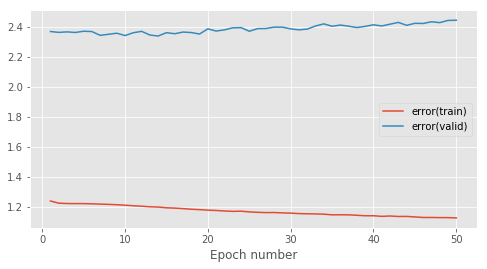

In [92]:
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

## Test on 6 validation data

Error:    0.824499799865
Actual motion length: (33656, 6), prediction length: (32972, 6)


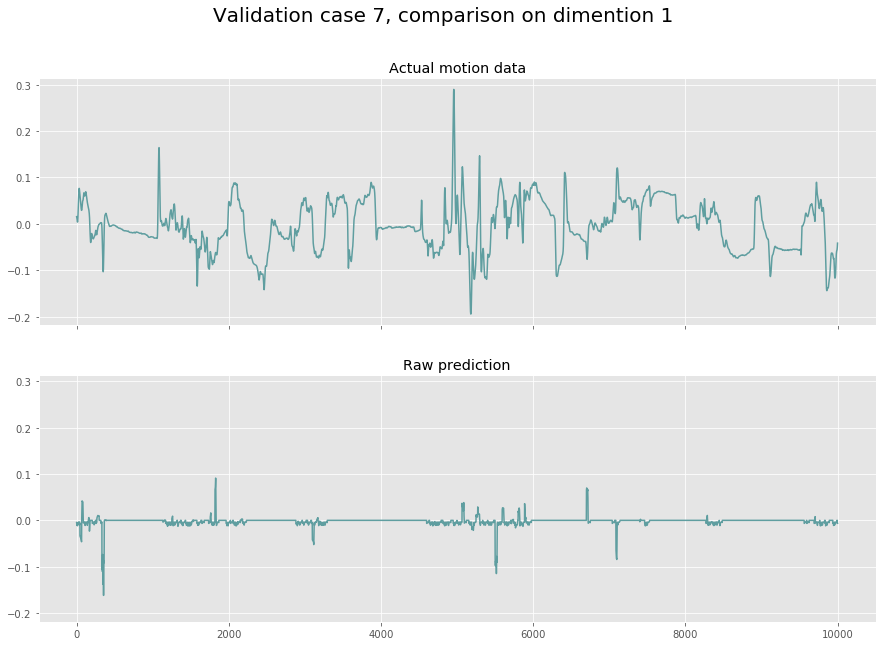

Error:    2.97522573866
Actual motion length: (29205, 6), prediction length: (28781, 6)


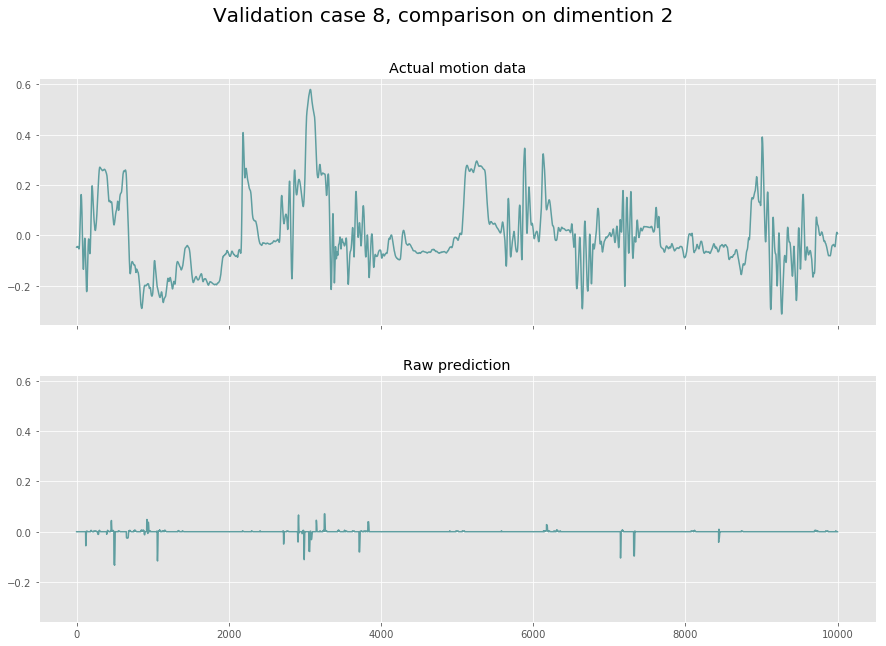

Error:    0.571370492579
Actual motion length: (32013, 6), prediction length: (31634, 6)


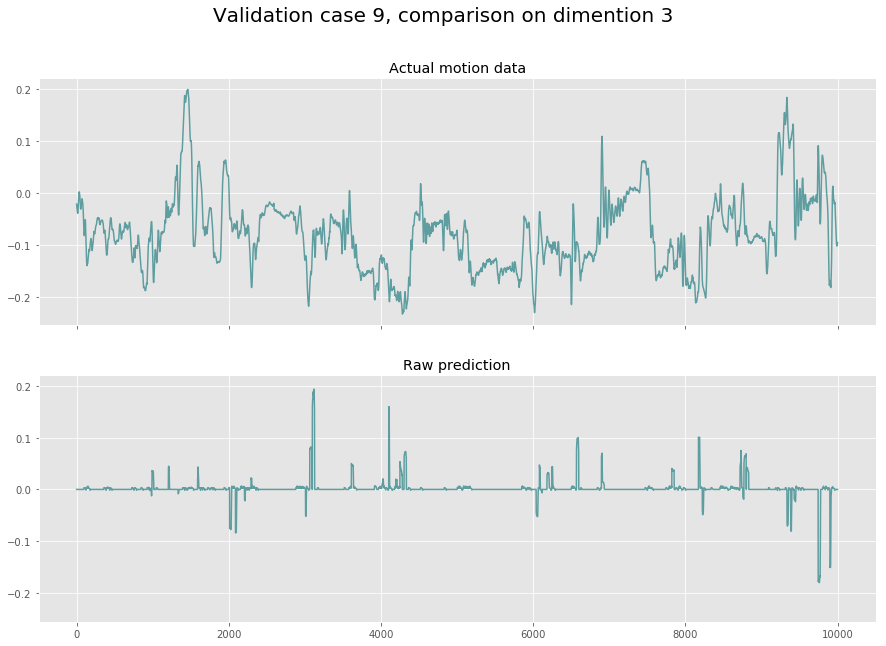

Error:    0.304783078011
Actual motion length: (30751, 6), prediction length: (30636, 6)


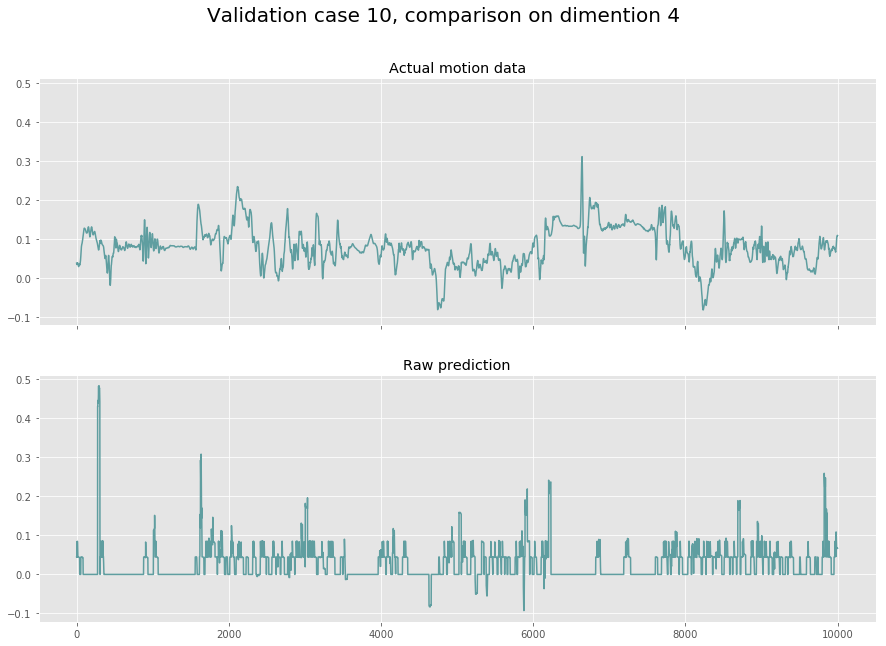

Error:    1.11952014634
Actual motion length: (31759, 6), prediction length: (31671, 6)


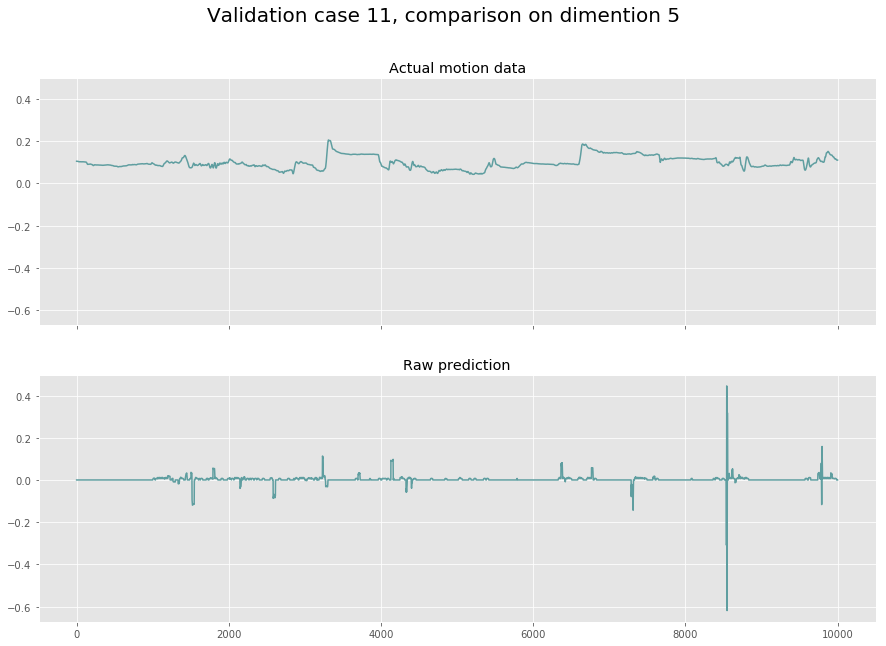

Error:    3.46836059854
Actual motion length: (30992, 6), prediction length: (30892, 6)


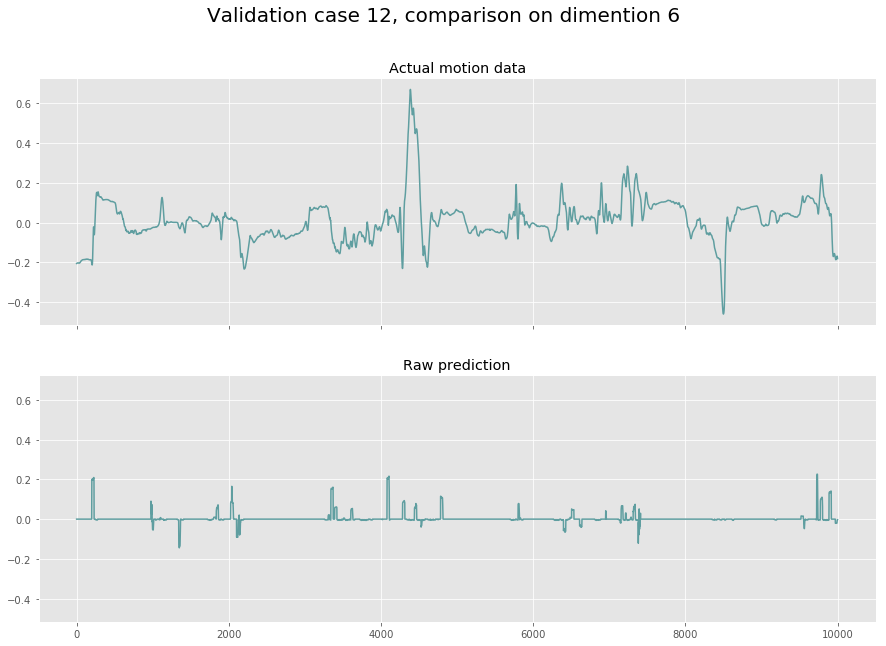

In [94]:
for i in range(7,13):
    validation_data = HMS300dDataProvider('validation{0}'.format(i), 'extro', rng=rng)
    result, evaluation = optimiser.eval_test_set(validation_data, 'validation')
    print('Error:    ' + str(evaluation['errorvalidation']))

    result_reshape = np.zeros((result[-1].shape[0], 6, 20)) # needs testig
    for j in range(result[-1].shape[0]):
        result_reshape[j] = result[-1][j].reshape(6,20)    
    
    time_intervals = np.loadtxt("ExtrovertRawData/Words/{}".format(i), usecols=range(4, 6), dtype="int")
    words = np.loadtxt("ExtrovertRawData/Words/{}".format(i), usecols=range(3, 4), dtype="str")
    
    prediction = np.zeros((6, time_intervals[-1,1] + window_size))
    counter = 0
    for index, line in enumerate(time_intervals):
        word = words[index]
        word_split = word.split('\'')
        
        if len(word_split) <= 1:   
            start_time = line[0]
            end_time = line[1]
            fading_point = end_time - start_time
            
            for k in range(6):
                frame = np.zeros(window_size)
                frame[0:number_of_frequency] = result_reshape[counter][k][0:number_of_frequency]
                dct_motion = dct(frame, 3, norm="ortho")
                faded_motion = fade_motion(dct_motion, fading_point, window_size)
                prediction[k, start_time:start_time + window_size] += faded_motion 
            counter += 1
        else:
            start_time = line[0]
            end_time = line[1]
            mid = int((line[0] + line[1]) / 2)
            fading_point_1 = mid - start_time
            fading_point_2 = end_time - mid
            
            for k in range(6):
                frame_1 = np.zeros(window_size)
                frame_1[0:number_of_frequency] = result_reshape[counter][k][0:number_of_frequency]
                dct_motion_1 = dct(frame_1, 3, norm="ortho")
                faded_motion_1 = fade_motion(dct_motion_1, fading_point_1, window_size)
                prediction[k, start_time:start_time + window_size] += faded_motion_1
                
                frame_2 = np.zeros(window_size)
                frame_2[0:number_of_frequency] = result_reshape[counter+1][k][0:number_of_frequency]
                dct_motion_2 = dct(frame_2, 3, norm="ortho")
                faded_motion_2 = fade_motion(dct_motion_2, fading_point_2, window_size)
                prediction[k, mid:mid + window_size] += faded_motion_2
            counter += 2
        
    prediction = prediction.transpose()
    smoothed_prediction = smooth_prediction(prediction)
    
    motion_data = np.loadtxt("ExtrovertRawData/Motion/{}.rov".format(i), skiprows=17, usecols=range(0, 6))

    print("Actual motion length: {}, prediction length: {}".format(motion_data.shape, prediction.shape))
    
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(15,10))
    axarr[0].plot(motion_data[10000:20000,i-7], color = 'cadetblue')
    axarr[0].set_title('Actual motion data')
    axarr[1].plot(prediction[10000:20000,i-7], color = 'cadetblue')
    axarr[1].set_title('Raw prediction')
#     axarr[2].plot(smoothed_prediction[10000:20000,i-7], color = 'cadetblue')
#     axarr[2].set_title('Smoothed prediction')
    
    plt.suptitle('Validation case {0}, comparison on dimention {1}'.format(i, i-6), size = 20)
    #plt.savefig('Validation case {0}, comparison on dimention {1}.pdf'.format(i, i-6))
    plt.show()

## Test different batch sizes:

Epoch Progress: 100%|██████████| 1140/1140 [00:03<00:00, 351.03it/s]Epoch 1: 3.3s to complete
    error(train)=1.24e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:03<00:00, 360.93it/s]Epoch 2: 3.2s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 399.88it/s]Epoch 3: 2.9s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress:  52%|█████▏    | 592/1140 [00:01<00:01, 386.42it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 396.43it/s]Epoch 4: 2.9s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 409.44it/s]Epoch 5: 2.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 404.30it/s]Epoch 6: 2.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 398.95it/s]Epoch 7: 2.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.34e+00, acc(valid)=6.16e-01
Epoch Progress:  18%|█▊        | 204/1140 [00:00<00:02, 397.67it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:02<00:00, 407.85it/s]Epoch 8: 2.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.35e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:03<00:00, 363.04it/s]Epoch 9: 3.2s to complete
    error(train)=1.22e+00, acc(train)=3.53e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:03<00:00, 291.13it/s]Epoch 10: 3.9s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.34e+00, acc(valid)=6.15e-01
Epoch Progress:  31%|███       | 350/1140 [00:01<00:03, 256.46it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:04<00:00, 260.02it/s]Epoch 11: 4.4s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:05<00:00, 221.87it/s]Epoch 12: 5.1s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress:  49%|████▉     | 562/1140 [00:02<00:03, 186.31it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 188.51it/s]Epoch 13: 6.1s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.35e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 173.89it/s]Epoch 14: 6.6s to complete
    error(train)=1.20e+00, acc(train)=3.54e-01, error(valid)=2.34e+00, acc(valid)=6.12e-01
Epoch Progress:  20%|██        | 233/1140 [00:01<00:05, 158.41it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:06<00:00, 164.58it/s]Epoch 15: 6.9s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.36e+00, acc(valid)=6.06e-01
Epoch Progress:  83%|████████▎ | 950/1140 [00:06<00:01, 152.52it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 154.01it/s]Epoch 16: 7.4s to complete
    error(train)=1.19e+00, acc(train)=3.55e-01, error(valid)=2.35e+00, acc(valid)=6.08e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 153.87it/s]Epoch 17: 7.4s to complete
    error(train)=1.19e+00, acc(train)=3.57e-01, error(valid)=2.36e+00, acc(valid)=6.05e-01
Epoch Progress:  34%|███▎      | 382/1140 [00:02<00:05, 150.48it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 152.25it/s]Epoch 18: 7.5s to complete
    error(train)=1.19e+00, acc(train)=3.58e-01, error(valid)=2.36e+00, acc(valid)=6.05e-01
Epoch Progress:  88%|████████▊ | 1003/1140 [00:06<00:00, 144.93it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.82it/s]Epoch 19: 7.6s to complete
    error(train)=1.18e+00, acc(train)=3.58e-01, error(valid)=2.35e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.49it/s]
Epoch 20: 7.6s to complete
    error(train)=1.18e+00, acc(train)=3.59e-01, error(valid)=2.39e+00, acc(valid)=6.00e-01
Epoch Progress:  36%|███▌      | 408/1140 [00:02<00:05, 146.14it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 150.49it/s]Epoch 21: 7.6s to complete
    error(train)=1.18e+00, acc(train)=3.58e-01, error(valid)=2.37e+00, acc(valid)=6.03e-01
Epoch Progress:  92%|█████████▏| 1049/1140 [00:06<00:00, 151.49it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 150.79it/s]Epoch 22: 7.6s to complete
    error(train)=1.17e+00, acc(train)=3.59e-01, error(valid)=2.38e+00, acc(valid)=5.97e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.13it/s]Epoch 23: 7.6s to complete
    error(train)=1.17e+00, acc(train)=3.60e-01, error(valid)=2.39e+00, acc(valid)=5.98e-01
Epoch Progress:  40%|███▉      | 454/1140 [00:03<00:04, 140.71it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 148.48it/s]Epoch 24: 7.7s to complete
    error(train)=1.17e+00, acc(train)=3.58e-01, error(valid)=2.39e+00, acc(valid)=5.97e-01
Epoch Progress:  93%|█████████▎| 1055/1140 [00:07<00:00, 147.51it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 148.31it/s]Epoch 25: 7.7s to complete
    error(train)=1.17e+00, acc(train)=3.61e-01, error(valid)=2.37e+00, acc(valid)=6.00e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.03it/s]Epoch 26: 7.6s to complete
    error(train)=1.17e+00, acc(train)=3.61e-01, error(valid)=2.39e+00, acc(valid)=5.98e-01
Epoch Progress:  41%|████      | 463/1140 [00:03<00:04, 145.40it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 150.39it/s]Epoch 27: 7.6s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.39e+00, acc(valid)=5.99e-01
Epoch Progress:  95%|█████████▍| 1078/1140 [00:07<00:00, 146.20it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.25it/s]Epoch 28: 7.6s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.40e+00, acc(valid)=5.97e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.71it/s]Epoch 29: 7.6s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.40e+00, acc(valid)=5.97e-01
Epoch Progress:  40%|████      | 459/1140 [00:03<00:04, 147.78it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 151.03it/s]Epoch 30: 7.6s to complete
    error(train)=1.16e+00, acc(train)=3.61e-01, error(valid)=2.39e+00, acc(valid)=5.97e-01
Epoch Progress:  90%|████████▉ | 1023/1140 [00:07<00:01, 105.40it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 136.97it/s]Epoch 31: 8.3s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=5.96e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 144.44it/s]Epoch 32: 7.9s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=6.01e-01
Epoch Progress:  33%|███▎      | 381/1140 [00:02<00:05, 145.89it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 150.73it/s]Epoch 33: 7.6s to complete
    error(train)=1.15e+00, acc(train)=3.63e-01, error(valid)=2.41e+00, acc(valid)=5.94e-01
Epoch Progress:  87%|████████▋ | 997/1140 [00:06<00:00, 145.56it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.07it/s]Epoch 34: 7.7s to complete
    error(train)=1.15e+00, acc(train)=3.64e-01, error(valid)=2.42e+00, acc(valid)=5.90e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.76it/s]Epoch 35: 7.6s to complete
    error(train)=1.15e+00, acc(train)=3.65e-01, error(valid)=2.40e+00, acc(valid)=5.94e-01
Epoch Progress:  33%|███▎      | 377/1140 [00:02<00:05, 146.56it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.93it/s]Epoch 36: 7.6s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress:  86%|████████▌ | 983/1140 [00:06<00:01, 148.07it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 154.62it/s]
Epoch 37: 7.7s to complete
    error(train)=1.15e+00, acc(train)=3.65e-01, error(valid)=2.40e+00, acc(valid)=5.91e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.65it/s]Epoch 38: 7.6s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.39e+00, acc(valid)=5.99e-01
Epoch Progress:  33%|███▎      | 377/1140 [00:02<00:05, 139.15it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 148.09it/s]Epoch 39: 7.7s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.40e+00, acc(valid)=5.96e-01
Epoch Progress:  85%|████████▌ | 973/1140 [00:06<00:01, 147.14it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 147.54it/s]Epoch 40: 7.7s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.41e+00, acc(valid)=5.92e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.07it/s]Epoch 41: 7.7s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress:  32%|███▏      | 366/1140 [00:02<00:05, 147.36it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 149.77it/s]Epoch 42: 7.6s to complete
    error(train)=1.14e+00, acc(train)=3.66e-01, error(valid)=2.42e+00, acc(valid)=5.84e-01
Epoch Progress:  85%|████████▌ | 973/1140 [00:06<00:01, 145.27it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 148.67it/s]Epoch 43: 7.7s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.43e+00, acc(valid)=5.93e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 142.47it/s]Epoch 44: 8.0s to complete
    error(train)=1.14e+00, acc(train)=3.68e-01, error(valid)=2.41e+00, acc(valid)=5.96e-01
Epoch Progress:  28%|██▊       | 317/1140 [00:02<00:05, 145.06it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 138.19it/s]Epoch 45: 8.3s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.42e+00, acc(valid)=5.94e-01
Epoch Progress:  78%|███████▊  | 893/1140 [00:05<00:01, 132.74it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 145.71it/s]Epoch 46: 7.8s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.42e+00, acc(valid)=5.92e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 153.00it/s]
Epoch 47: 7.9s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.43e+00, acc(valid)=5.87e-01
Epoch Progress:  23%|██▎       | 260/1140 [00:01<00:06, 146.43it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 146.75it/s]Epoch 48: 7.8s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.43e+00, acc(valid)=5.87e-01
Epoch Progress:  75%|███████▍  | 854/1140 [00:05<00:02, 139.42it/s]


Epoch Progress: 100%|██████████| 1140/1140 [00:07<00:00, 148.48it/s]Epoch 49: 7.7s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.44e+00, acc(valid)=5.84e-01
Epoch Progress: 100%|██████████| 1140/1140 [00:08<00:00, 138.51it/s]Epoch 50: 8.2s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.44e+00, acc(valid)=5.85e-01
Experiment Progress: 100%|██████████| 50/50 [05:48<00:00,  8.41s/it]


Error:    0.824499799865
Actual motion length: (33656, 6), prediction length: (32972, 6)


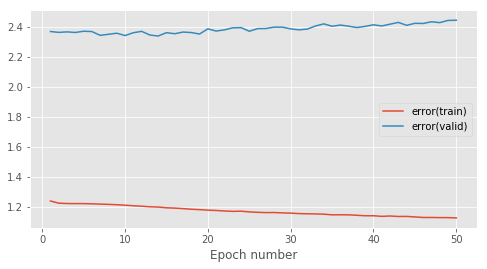

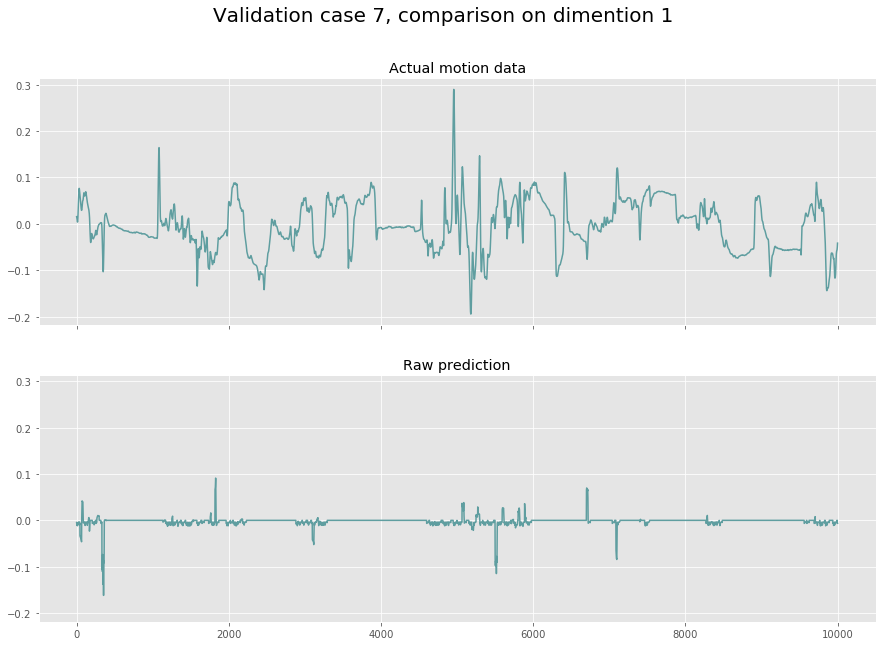

Error:    2.97522573866
Actual motion length: (29205, 6), prediction length: (28781, 6)


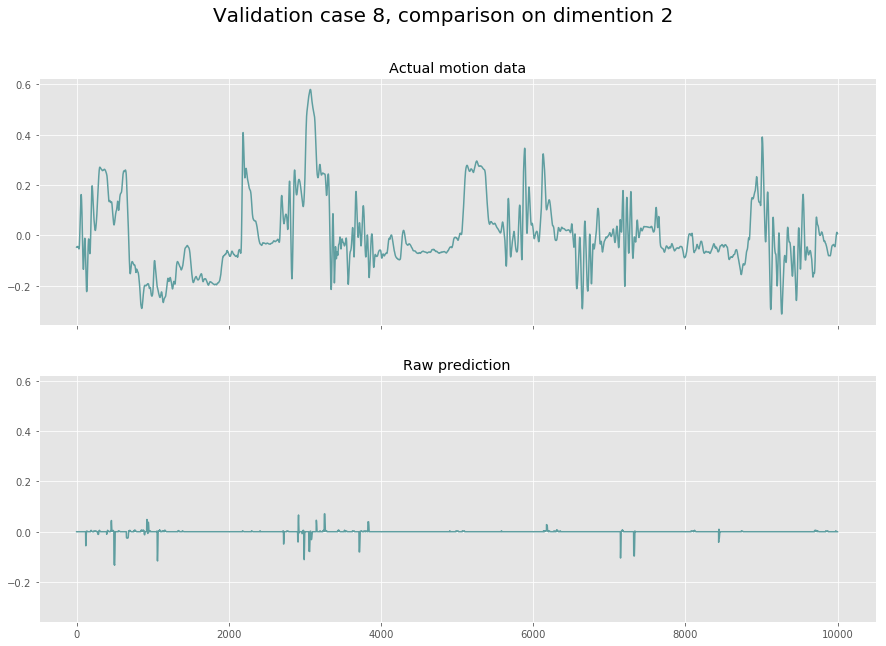

Error:    0.571370492579
Actual motion length: (32013, 6), prediction length: (31634, 6)


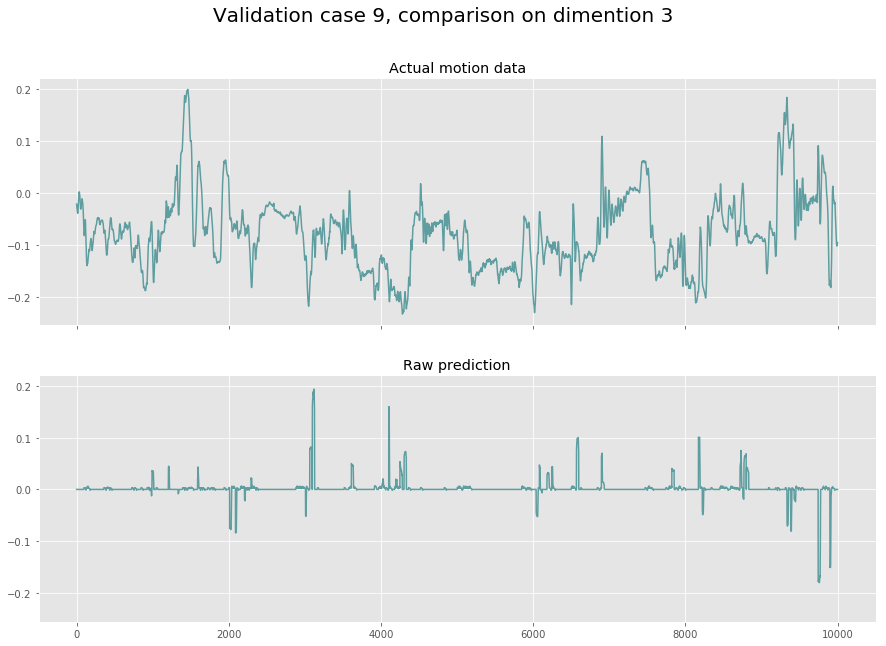

Error:    0.304783078011
Actual motion length: (30751, 6), prediction length: (30636, 6)


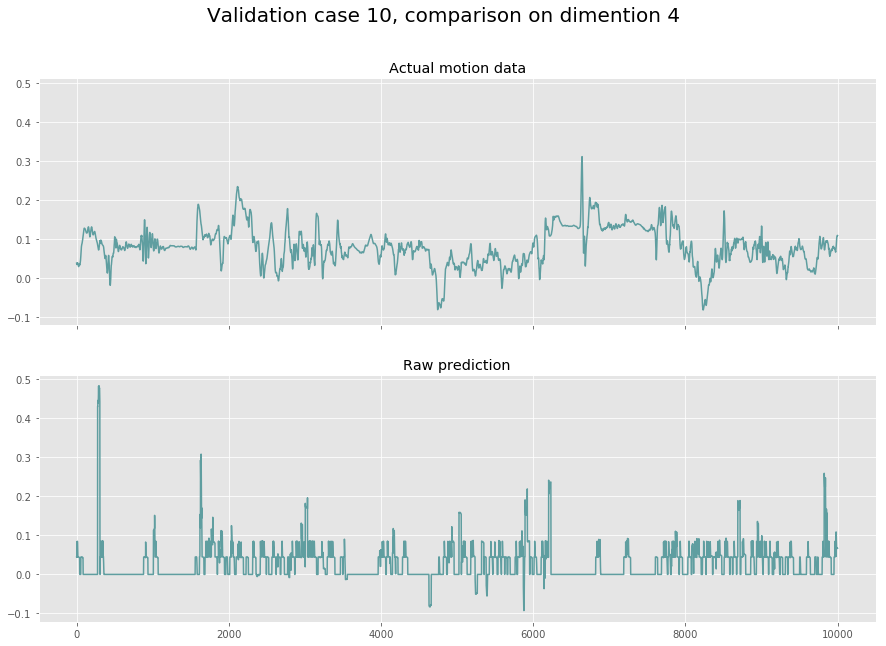

Error:    1.11952014634
Actual motion length: (31759, 6), prediction length: (31671, 6)


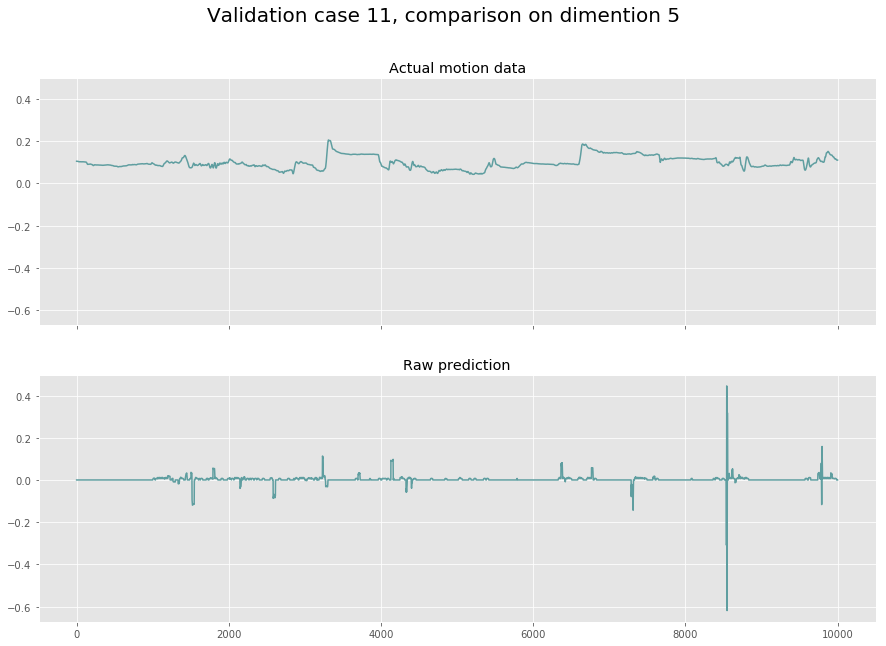

Error:    3.46836059854
Actual motion length: (30992, 6), prediction length: (30892, 6)


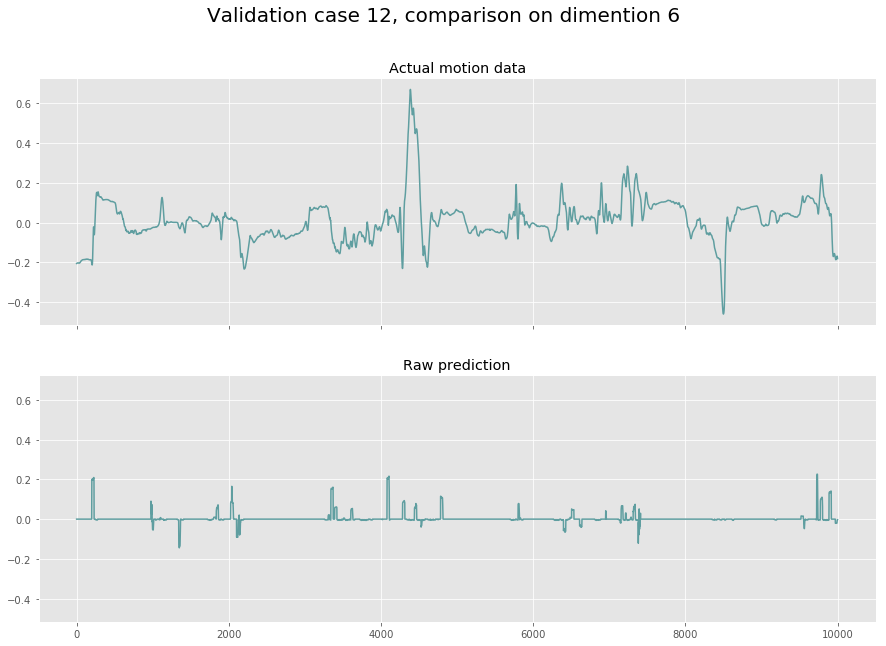

Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 347.94it/s]Epoch 1: 1.6s to complete
    error(train)=1.24e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 333.80it/s]Epoch 2: 1.7s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 353.84it/s]Epoch 3: 1.6s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 317.12it/s]Epoch 4: 1.8s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 570/570 [00:02<00:00, 259.59it/s]Epoch 5: 2.2s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.17e-01
Epoch Progress:  75%|███████▍  | 425/570 [00:01<00:00, 321.00it/s]


Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 308.96it/s]Epoch 6: 1.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 295.57it/s]Epoch 7: 1.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.34e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 316.13it/s]Epoch 8: 1.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 299.66it/s]Epoch 9: 1.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 292.76it/s]Epoch 10: 2.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.35e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 323.39it/s]Epoch 11: 1.8s to 

Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 331.96it/s]Epoch 12: 1.7s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 290.46it/s]Epoch 13: 2.0s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.35e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 351.48it/s]Epoch 14: 1.6s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.36e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 346.46it/s]
Epoch 15: 1.7s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.36e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 299.62it/s]Epoch 16: 1.9s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.36e+00, acc(valid)=6.10e-01
Epoch Progress:  95%|█████████▌| 544/570 [00:01<00:00, 328.81it/s]


Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 309.13it/s]Epoch 17: 1.9s to complete
    error(train)=1.20e+00, acc(train)=3.57e-01, error(valid)=2.36e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 337.31it/s]Epoch 18: 1.7s to complete
    error(train)=1.19e+00, acc(train)=3.57e-01, error(valid)=2.37e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 288.13it/s]Epoch 19: 2.0s to complete
    error(train)=1.19e+00, acc(train)=3.58e-01, error(valid)=2.37e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 570/570 [00:01<00:00, 291.74it/s]Epoch 20: 2.0s to complete
    error(train)=1.19e+00, acc(train)=3.60e-01, error(valid)=2.40e+00, acc(valid)=5.99e-01
Epoch Progress: 100%|██████████| 570/570 [00:02<00:00, 254.07it/s]Epoch 21: 2.3s to complete
    error(train)=1.18e+00, acc(train)=3.60e-01, error(valid)=2.38e+00, acc(valid)=5.99e-01
Epoch Progress:  90%|█████████ | 515/570 [00:02<00:00, 214.76it/s]


Epoch Progress: 100%|██████████| 570/570 [00:02<00:00, 221.71it/s]Epoch 22: 2.6s to complete
    error(train)=1.18e+00, acc(train)=3.62e-01, error(valid)=2.38e+00, acc(valid)=6.02e-01
Epoch Progress: 100%|██████████| 570/570 [00:02<00:00, 216.21it/s]Epoch 23: 2.6s to complete
    error(train)=1.18e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=5.96e-01
Epoch Progress: 100%|██████████| 570/570 [00:02<00:00, 190.77it/s]Epoch 24: 3.0s to complete
    error(train)=1.17e+00, acc(train)=3.63e-01, error(valid)=2.39e+00, acc(valid)=5.96e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 175.21it/s]Epoch 25: 3.3s to complete
    error(train)=1.17e+00, acc(train)=3.65e-01, error(valid)=2.38e+00, acc(valid)=5.87e-01
Epoch Progress:  42%|████▏     | 237/570 [00:01<00:02, 154.49it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 163.57it/s]Epoch 26: 3.5s to complete
    error(train)=1.17e+00, acc(train)=3.65e-01, error(valid)=2.39e+00, acc(valid)=5.95e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 157.32it/s]
Epoch 27: 3.6s to complete
    error(train)=1.16e+00, acc(train)=3.65e-01, error(valid)=2.39e+00, acc(valid)=5.94e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 150.03it/s]Epoch 28: 3.8s to complete
    error(train)=1.16e+00, acc(train)=3.66e-01, error(valid)=2.38e+00, acc(valid)=5.97e-01
Epoch Progress:  44%|████▎     | 248/570 [00:01<00:02, 147.37it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 151.53it/s]Epoch 29: 3.8s to complete
    error(train)=1.16e+00, acc(train)=3.67e-01, error(valid)=2.40e+00, acc(valid)=5.84e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 150.02it/s]Epoch 30: 3.8s to complete
    error(train)=1.15e+00, acc(train)=3.69e-01, error(valid)=2.39e+00, acc(valid)=5.91e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 148.45it/s]Epoch 31: 3.9s to complete
    error(train)=1.15e+00, acc(train)=3.68e-01, error(valid)=2.39e+00, acc(valid)=5.88e-01
Epoch Progress:  32%|███▏      | 183/570 [00:01<00:02, 144.85it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 150.44it/s]Epoch 32: 3.8s to complete
    error(train)=1.15e+00, acc(train)=3.69e-01, error(valid)=2.39e+00, acc(valid)=5.86e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 149.40it/s]Epoch 33: 3.8s to complete
    error(train)=1.14e+00, acc(train)=3.70e-01, error(valid)=2.42e+00, acc(valid)=5.79e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 145.72it/s]Epoch 34: 3.9s to complete
    error(train)=1.14e+00, acc(train)=3.71e-01, error(valid)=2.41e+00, acc(valid)=5.77e-01
Epoch Progress:  19%|█▉        | 107/570 [00:00<00:03, 145.33it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 148.93it/s]Epoch 35: 3.8s to complete
    error(train)=1.14e+00, acc(train)=3.70e-01, error(valid)=2.41e+00, acc(valid)=5.78e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 147.81it/s]Epoch 36: 3.9s to complete
    error(train)=1.14e+00, acc(train)=3.72e-01, error(valid)=2.42e+00, acc(valid)=5.80e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 145.52it/s]Epoch 37: 3.9s to complete
    error(train)=1.14e+00, acc(train)=3.71e-01, error(valid)=2.41e+00, acc(valid)=5.82e-01
Epoch Progress:   5%|▌         | 31/570 [00:00<00:03, 148.03it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 148.72it/s]
Epoch 38: 3.8s to complete
    error(train)=1.14e+00, acc(train)=3.73e-01, error(valid)=2.41e+00, acc(valid)=5.85e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 146.70it/s]Epoch 39: 3.9s to complete
    error(train)=1.13e+00, acc(train)=3.72e-01, error(valid)=2.42e+00, acc(valid)=5.84e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 145.22it/s]Epoch 40: 3.9s to complete
    error(train)=1.13e+00, acc(train)=3.74e-01, error(valid)=2.41e+00, acc(valid)=5.82e-01


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 150.82it/s]Epoch 41: 3.8s to complete
    error(train)=1.13e+00, acc(train)=3.73e-01, error(valid)=2.43e+00, acc(valid)=5.79e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 147.11it/s]
Epoch 42: 4.0s to complete
    error(train)=1.13e+00, acc(train)=3.73e-01, error(valid)=2.43e+00, acc(valid)=5.76e-01
Epoch Progress:  93%|█████████▎| 528/570 [00:03<00:00, 143.35it/s]


Epoch Progress: 100%|██████████| 570/570 [00:04<00:00, 142.37it/s]Epoch 43: 4.0s to complete
    error(train)=1.12e+00, acc(train)=3.74e-01, error(valid)=2.42e+00, acc(valid)=5.82e-01
Epoch Progress: 100%|██████████| 570/570 [00:04<00:00, 136.03it/s]Epoch 44: 4.2s to complete
    error(train)=1.12e+00, acc(train)=3.74e-01, error(valid)=2.42e+00, acc(valid)=5.83e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 144.25it/s]Epoch 45: 4.0s to complete
    error(train)=1.12e+00, acc(train)=3.76e-01, error(valid)=2.44e+00, acc(valid)=5.72e-01
Epoch Progress:  68%|██████▊   | 390/570 [00:02<00:01, 143.51it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 145.64it/s]Epoch 46: 3.9s to complete
    error(train)=1.12e+00, acc(train)=3.75e-01, error(valid)=2.43e+00, acc(valid)=5.78e-01
Epoch Progress: 100%|██████████| 570/570 [00:04<00:00, 135.45it/s]Epoch 47: 4.2s to complete
    error(train)=1.12e+00, acc(train)=3.74e-01, error(valid)=2.43e+00, acc(valid)=5.75e-01
Epoch Progress: 100%|██████████| 570/570 [00:04<00:00, 139.98it/s]Epoch 48: 4.1s to complete
    error(train)=1.12e+00, acc(train)=3.75e-01, error(valid)=2.44e+00, acc(valid)=5.71e-01
Epoch Progress:  44%|████▍     | 251/570 [00:01<00:02, 140.53it/s]


Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 146.38it/s]Epoch 49: 3.9s to complete
    error(train)=1.12e+00, acc(train)=3.76e-01, error(valid)=2.43e+00, acc(valid)=5.81e-01
Epoch Progress: 100%|██████████| 570/570 [00:03<00:00, 143.15it/s]Epoch 50: 4.0s to complete
    error(train)=1.12e+00, acc(train)=3.76e-01, error(valid)=2.45e+00, acc(valid)=5.72e-01
Experiment Progress: 100%|██████████| 50/50 [02:42<00:00,  4.30s/it]


Error:    0.824316480458
Actual motion length: (33656, 6), prediction length: (32972, 6)


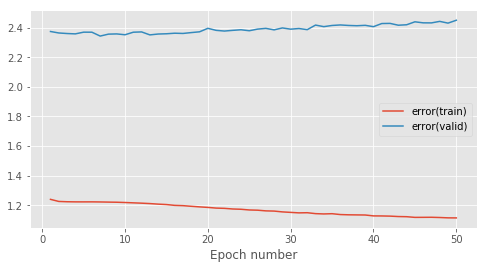

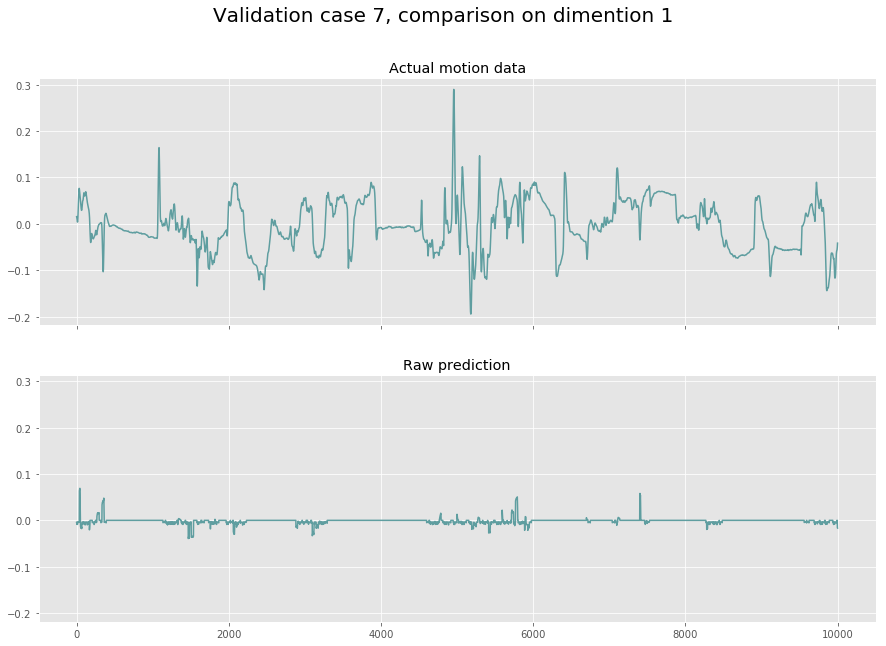

Error:    2.97203606155
Actual motion length: (29205, 6), prediction length: (28781, 6)


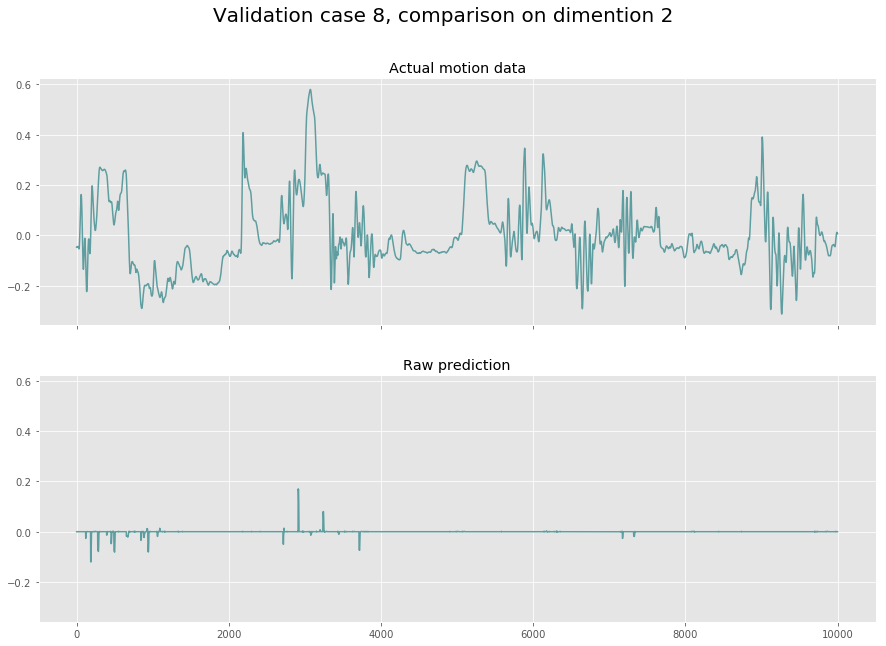

Error:    0.573875504281
Actual motion length: (32013, 6), prediction length: (31634, 6)


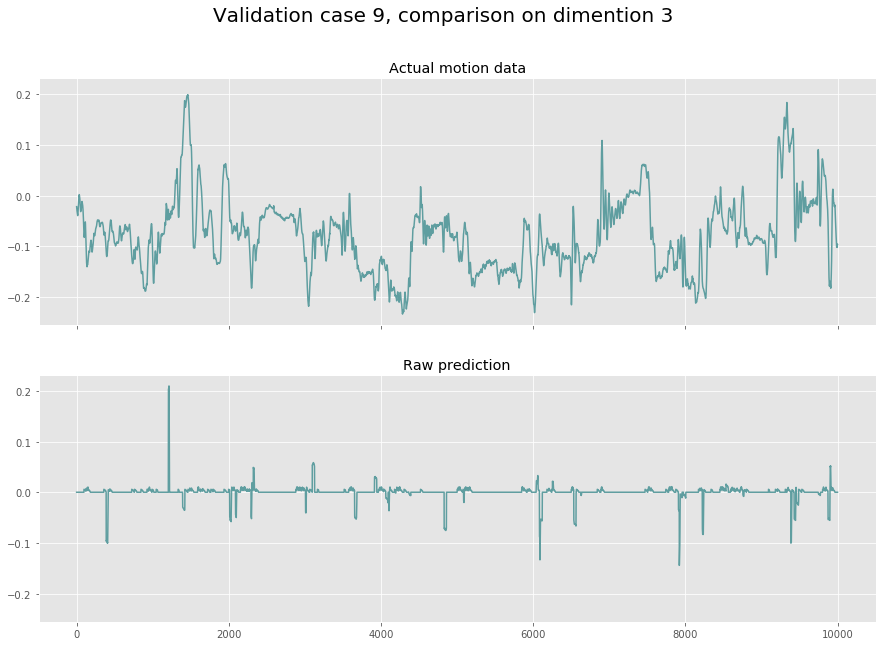

Error:    0.307958230223
Actual motion length: (30751, 6), prediction length: (30636, 6)


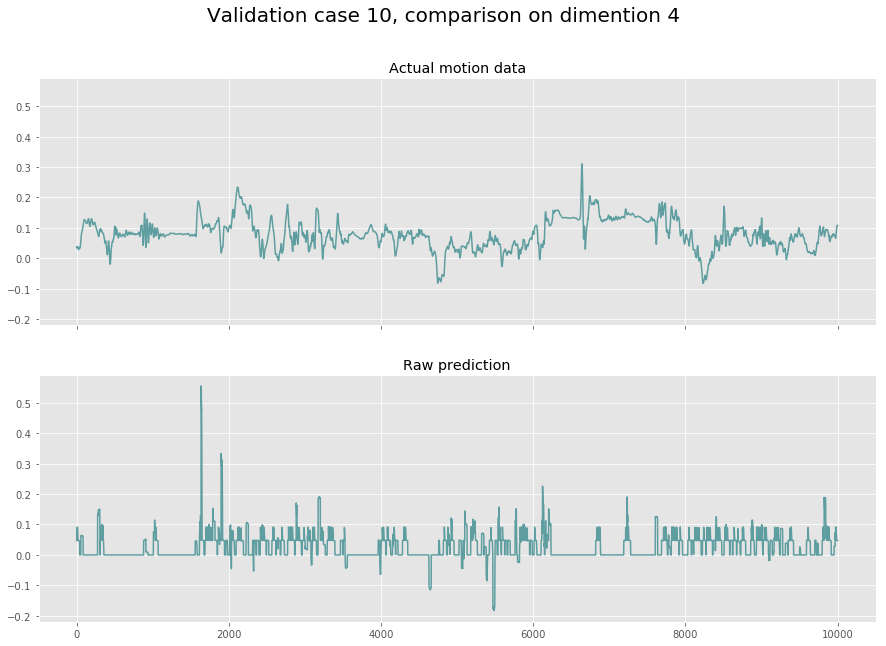

Error:    1.14489569542
Actual motion length: (31759, 6), prediction length: (31671, 6)


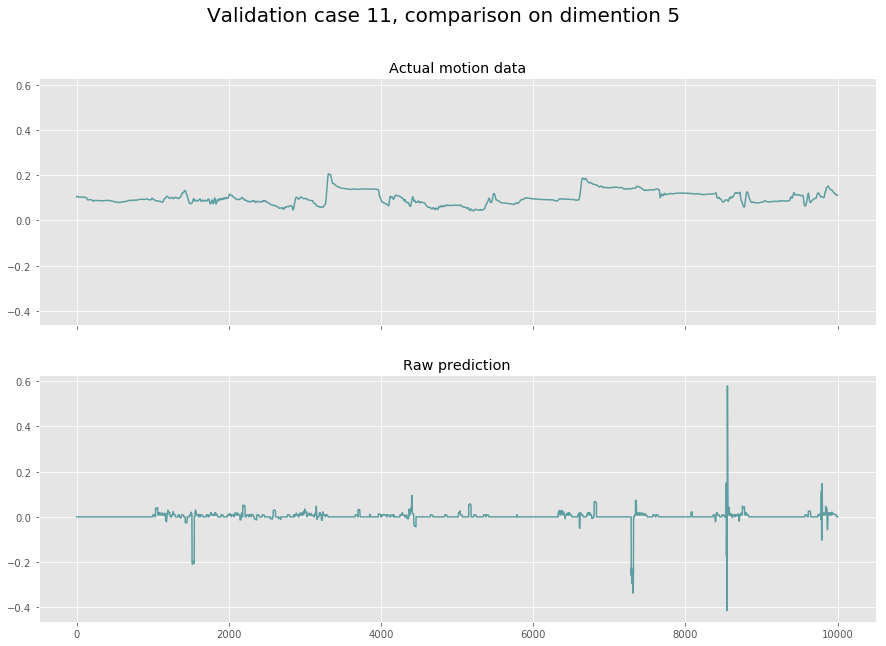

Error:    3.45527530614
Actual motion length: (30992, 6), prediction length: (30892, 6)


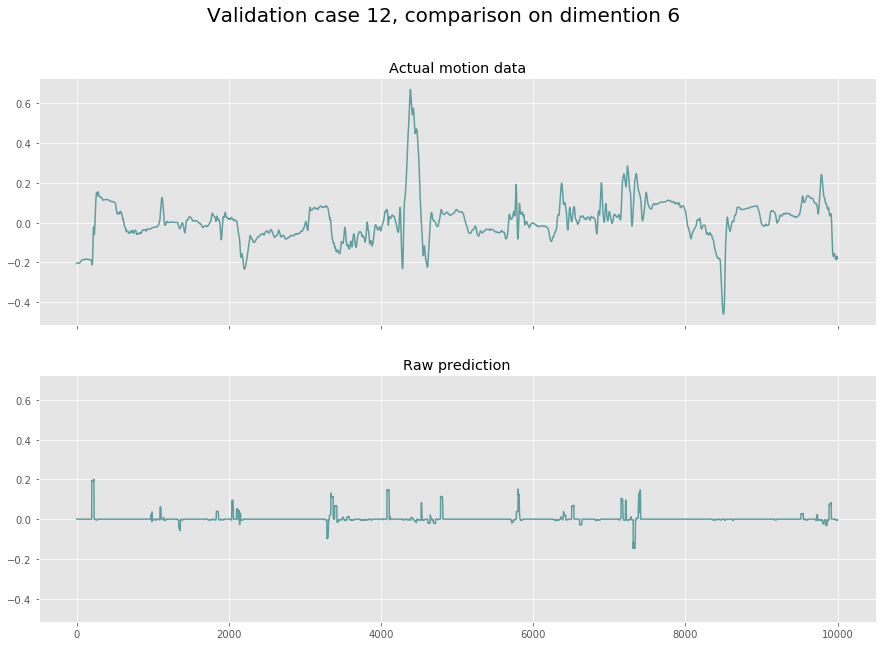

Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 341.96it/s]Epoch 1: 1.1s to complete
    error(train)=1.24e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 324.72it/s]Epoch 2: 1.2s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 288.17it/s]Epoch 3: 1.3s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 290.44it/s]Epoch 4: 1.3s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 281.31it/s]Epoch 5: 1.4s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 282.66it/s]Epoch 6: 1.4s to co

Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 319.46it/s]
Epoch 8: 1.3s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 336.80it/s]
Epoch 9: 1.1s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 326.89it/s]Epoch 10: 1.2s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.35e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 318.69it/s]Epoch 11: 1.2s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 313.20it/s]Epoch 12: 1.2s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 288.17it/s]Epoch 13: 1.3s

Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 282.43it/s]Epoch 16: 1.4s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.12e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 300.30it/s]Epoch 17: 1.3s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 308.78it/s]Epoch 18: 1.2s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.36e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 308.51it/s]Epoch 19: 1.2s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 306.63it/s]Epoch 20: 1.2s to complete
    error(train)=1.20e+00, acc(train)=3.54e-01, error(valid)=2.38e+00, acc(valid)=6.05e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 271.13it/s]Epoch 21: 1.4s

Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 331.57it/s]
Epoch 23: 1.3s to complete
    error(train)=1.20e+00, acc(train)=3.57e-01, error(valid)=2.37e+00, acc(valid)=6.09e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 326.35it/s]Epoch 24: 1.2s to complete
    error(train)=1.19e+00, acc(train)=3.57e-01, error(valid)=2.38e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 321.35it/s]Epoch 25: 1.2s to complete
    error(train)=1.19e+00, acc(train)=3.58e-01, error(valid)=2.36e+00, acc(valid)=6.08e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 309.04it/s]Epoch 26: 1.2s to complete
    error(train)=1.19e+00, acc(train)=3.57e-01, error(valid)=2.37e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 273.38it/s]Epoch 27: 1.4s to complete
    error(train)=1.18e+00, acc(train)=3.58e-01, error(valid)=2.39e+00, acc(valid)=6.00e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 286.41it/s]Epoch 28: 1.3

Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 235.43it/s]Epoch 30: 1.6s to complete
    error(train)=1.17e+00, acc(train)=3.60e-01, error(valid)=2.39e+00, acc(valid)=6.04e-01
Epoch Progress: 100%|██████████| 380/380 [00:01<00:00, 235.98it/s]Epoch 31: 1.6s to complete
    error(train)=1.17e+00, acc(train)=3.60e-01, error(valid)=2.38e+00, acc(valid)=6.03e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 176.72it/s]Epoch 32: 2.2s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.38e+00, acc(valid)=6.05e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 173.91it/s]Epoch 33: 2.2s to complete
    error(train)=1.16e+00, acc(train)=3.61e-01, error(valid)=2.40e+00, acc(valid)=5.98e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 166.44it/s]Epoch 34: 2.3s to complete
    error(train)=1.16e+00, acc(train)=3.62e-01, error(valid)=2.40e+00, acc(valid)=5.95e-01
Epoch Progress:  58%|█████▊    | 221/380 [00:01<00:01, 135.88it/s]


Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 145.09it/s]Epoch 35: 2.6s to complete
    error(train)=1.15e+00, acc(train)=3.64e-01, error(valid)=2.39e+00, acc(valid)=5.92e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 156.19it/s]Epoch 36: 2.4s to complete
    error(train)=1.15e+00, acc(train)=3.64e-01, error(valid)=2.40e+00, acc(valid)=5.93e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 156.57it/s]Epoch 37: 2.4s to complete
    error(train)=1.15e+00, acc(train)=3.64e-01, error(valid)=2.40e+00, acc(valid)=5.89e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 133.25it/s]Epoch 38: 2.9s to complete
    error(train)=1.15e+00, acc(train)=3.63e-01, error(valid)=2.41e+00, acc(valid)=5.88e-01
Epoch Progress:  82%|████████▏ | 310/380 [00:02<00:00, 133.32it/s]


Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 144.07it/s]Epoch 39: 2.6s to complete
    error(train)=1.14e+00, acc(train)=3.65e-01, error(valid)=2.41e+00, acc(valid)=5.94e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 145.46it/s]Epoch 40: 2.6s to complete
    error(train)=1.14e+00, acc(train)=3.64e-01, error(valid)=2.40e+00, acc(valid)=5.92e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 140.69it/s]Epoch 41: 2.7s to complete
    error(train)=1.14e+00, acc(train)=3.65e-01, error(valid)=2.41e+00, acc(valid)=5.93e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 138.89it/s]Epoch 42: 2.7s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.41e+00, acc(valid)=5.89e-01
Epoch Progress:  84%|████████▍ | 321/380 [00:02<00:00, 143.09it/s]


Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 138.99it/s]Epoch 43: 2.7s to complete
    error(train)=1.13e+00, acc(train)=3.67e-01, error(valid)=2.42e+00, acc(valid)=5.83e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 135.07it/s]Epoch 44: 2.8s to complete
    error(train)=1.13e+00, acc(train)=3.68e-01, error(valid)=2.41e+00, acc(valid)=5.84e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 137.45it/s]Epoch 45: 2.8s to complete
    error(train)=1.13e+00, acc(train)=3.68e-01, error(valid)=2.43e+00, acc(valid)=5.85e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 139.60it/s]Epoch 46: 2.7s to complete
    error(train)=1.13e+00, acc(train)=3.69e-01, error(valid)=2.42e+00, acc(valid)=5.79e-01
Epoch Progress:  77%|███████▋  | 291/380 [00:02<00:00, 135.29it/s]


Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 139.69it/s]Epoch 47: 2.7s to complete
    error(train)=1.13e+00, acc(train)=3.70e-01, error(valid)=2.44e+00, acc(valid)=5.82e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 148.71it/s]Epoch 48: 2.6s to complete
    error(train)=1.12e+00, acc(train)=3.69e-01, error(valid)=2.43e+00, acc(valid)=5.79e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 135.39it/s]
Epoch 49: 2.6s to complete
    error(train)=1.12e+00, acc(train)=3.69e-01, error(valid)=2.44e+00, acc(valid)=5.77e-01
Epoch Progress: 100%|██████████| 380/380 [00:02<00:00, 142.07it/s]Epoch 50: 2.7s to complete
    error(train)=1.12e+00, acc(train)=3.68e-01, error(valid)=2.44e+00, acc(valid)=5.76e-01
Experiment Progress: 100%|██████████| 50/50 [01:44<00:00,  2.94s/it]


Error:    0.824802184791
Actual motion length: (33656, 6), prediction length: (32972, 6)


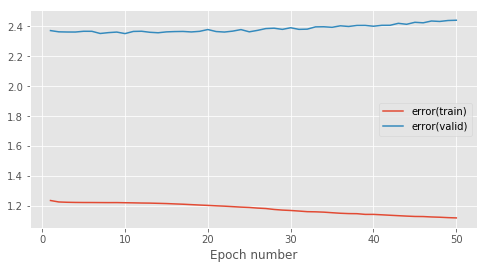

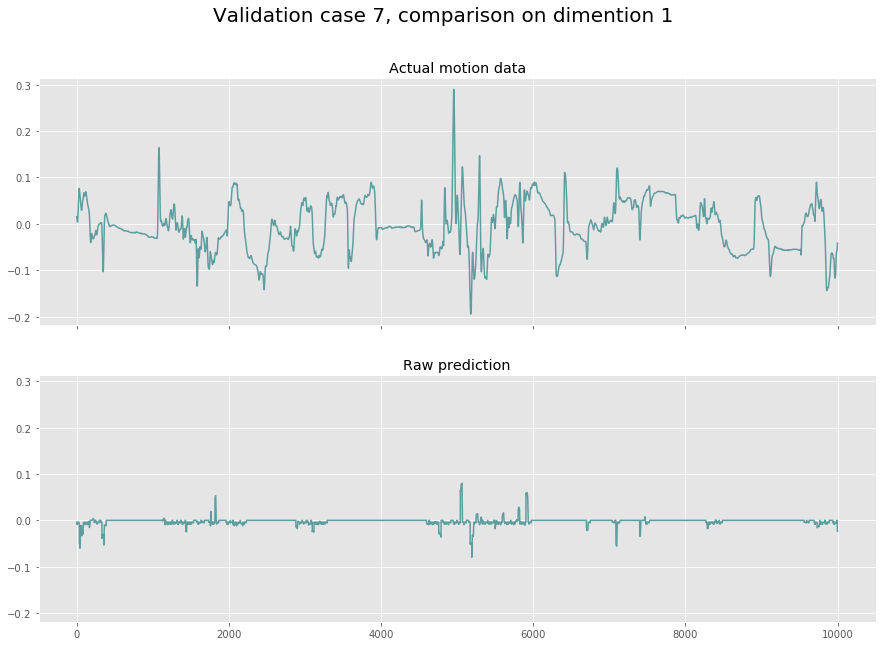

Error:    2.96798464307
Actual motion length: (29205, 6), prediction length: (28781, 6)


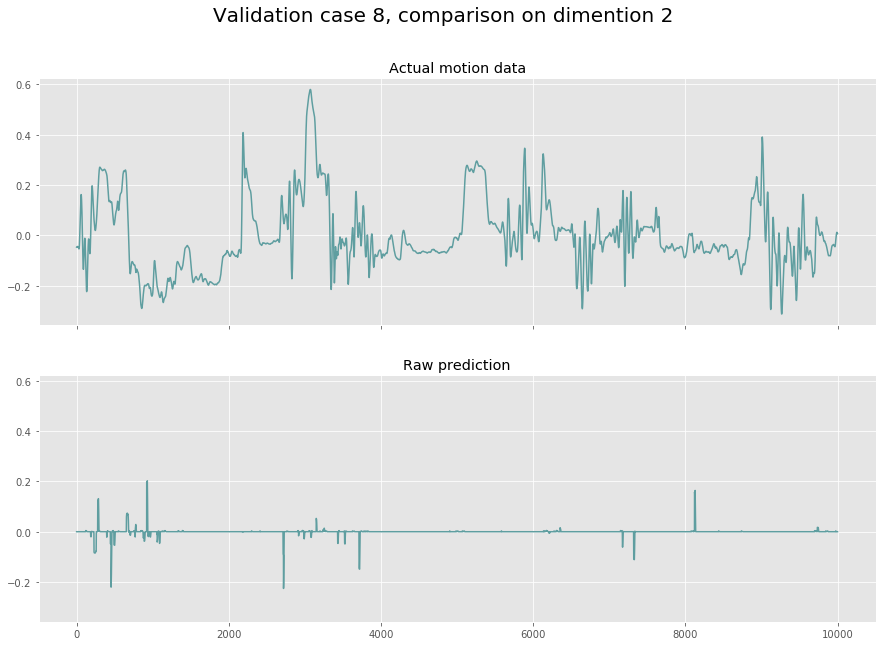

Error:    0.569984004198
Actual motion length: (32013, 6), prediction length: (31634, 6)


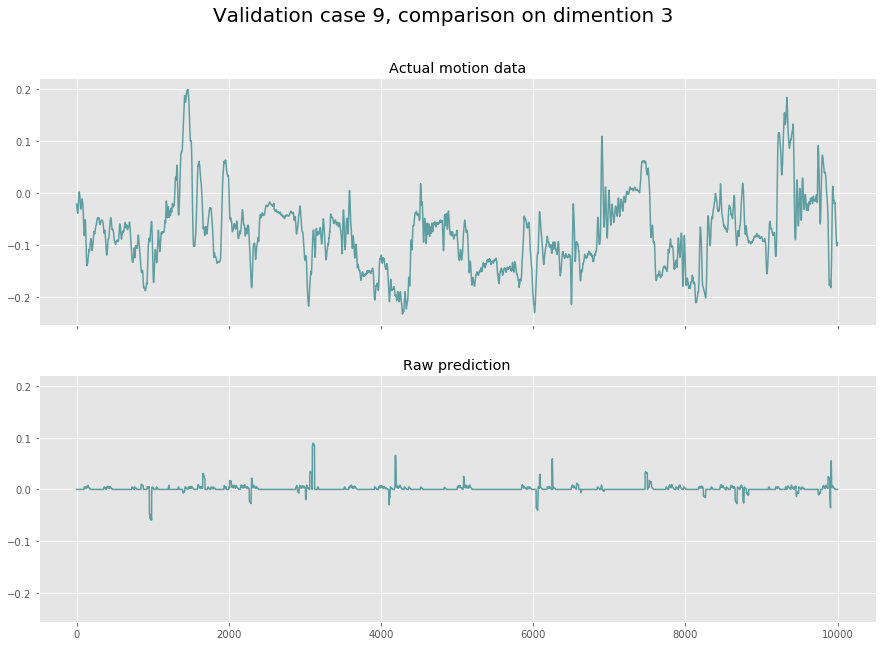

Error:    0.307495549931
Actual motion length: (30751, 6), prediction length: (30636, 6)


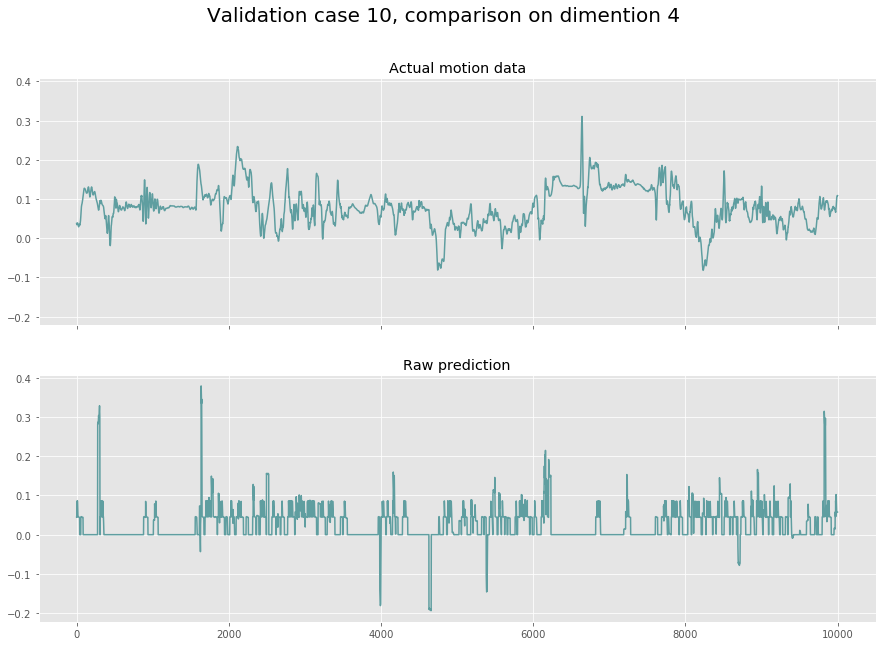

Error:    1.12614814186
Actual motion length: (31759, 6), prediction length: (31671, 6)


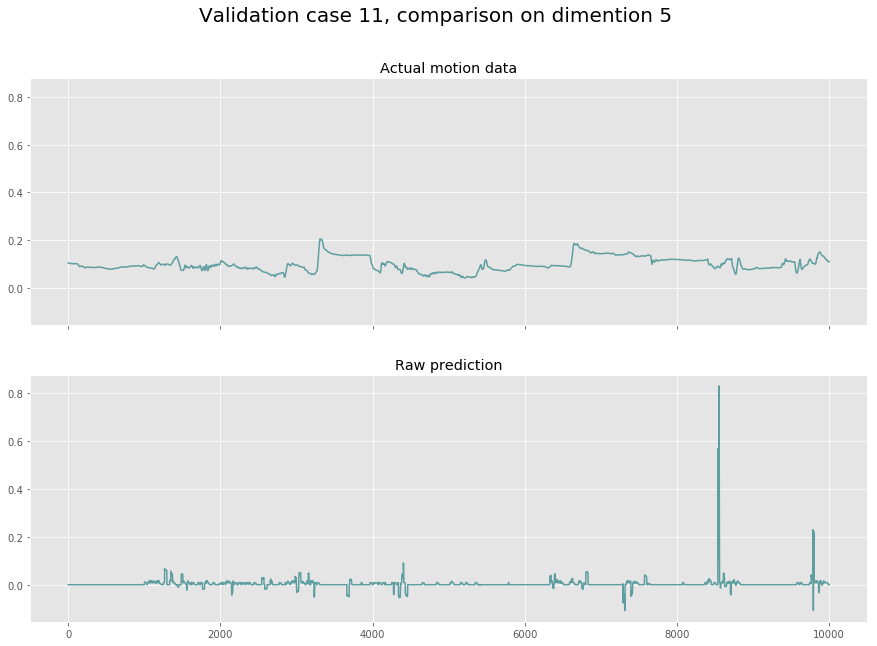

Error:    3.44715493812
Actual motion length: (30992, 6), prediction length: (30892, 6)


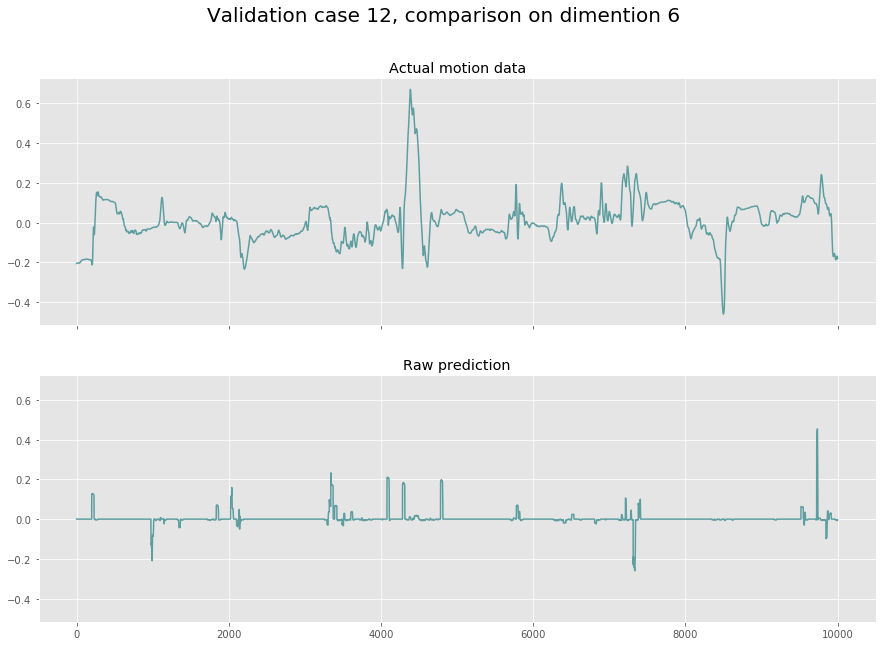

Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 314.12it/s]Epoch 1: 0.9s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.38e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 315.45it/s]Epoch 2: 0.9s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 307.20it/s]Epoch 3: 0.9s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 291.81it/s]Epoch 4: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 289.28it/s]
Epoch 5: 1.1s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.38e+00, acc(valid)=6.18e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 294.29it/s]Epoch 6: 1.0s to c

Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 306.20it/s]Epoch 10: 0.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 298.66it/s]Epoch 11: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 297.29it/s]Epoch 12: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 274.66it/s]Epoch 13: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.35e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 265.91it/s]Epoch 14: 1.1s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.17e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 267.85it/s]Epoch 15: 1.1s

Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 264.48it/s]Epoch 18: 1.1s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.12e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 311.82it/s]Epoch 19: 0.9s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 267.09it/s]Epoch 20: 1.1s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.38e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 296.84it/s]Epoch 21: 1.0s to complete
    error(train)=1.21e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.12e-01
Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 289.59it/s]Epoch 22: 1.0s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.37e+00, acc(valid)=6.08e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 264.00it/s]Epoch 23: 1.1s

Epoch Progress: 100%|██████████| 285/285 [00:00<00:00, 291.34it/s]Epoch 27: 1.0s to complete
    error(train)=1.19e+00, acc(train)=3.58e-01, error(valid)=2.39e+00, acc(valid)=6.08e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 283.54it/s]Epoch 28: 1.0s to complete
    error(train)=1.19e+00, acc(train)=3.59e-01, error(valid)=2.38e+00, acc(valid)=6.09e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 280.31it/s]Epoch 29: 1.0s to complete
    error(train)=1.19e+00, acc(train)=3.59e-01, error(valid)=2.38e+00, acc(valid)=6.07e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 277.66it/s]Epoch 30: 1.0s to complete
    error(train)=1.19e+00, acc(train)=3.59e-01, error(valid)=2.36e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 250.40it/s]Epoch 31: 1.1s to complete
    error(train)=1.18e+00, acc(train)=3.60e-01, error(valid)=2.39e+00, acc(valid)=6.04e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 254.45it/s]Epoch 32: 1.1s

Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 251.60it/s]Epoch 35: 1.1s to complete
    error(train)=1.17e+00, acc(train)=3.62e-01, error(valid)=2.39e+00, acc(valid)=6.01e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 279.34it/s]Epoch 36: 1.0s to complete
    error(train)=1.17e+00, acc(train)=3.63e-01, error(valid)=2.40e+00, acc(valid)=6.01e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 281.44it/s]Epoch 37: 1.0s to complete
    error(train)=1.17e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=6.01e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 264.03it/s]Epoch 38: 1.1s to complete
    error(train)=1.17e+00, acc(train)=3.63e-01, error(valid)=2.39e+00, acc(valid)=6.00e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 249.32it/s]Epoch 39: 1.2s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.38e+00, acc(valid)=6.04e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 232.76it/s]Epoch 40: 1.2s

Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 204.61it/s]Epoch 43: 1.4s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.40e+00, acc(valid)=5.98e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 205.83it/s]Epoch 44: 1.4s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.40e+00, acc(valid)=5.98e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 187.28it/s]Epoch 45: 1.5s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.41e+00, acc(valid)=5.93e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 178.62it/s]Epoch 46: 1.6s to complete
    error(train)=1.15e+00, acc(train)=3.66e-01, error(valid)=2.40e+00, acc(valid)=5.99e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 172.35it/s]Epoch 47: 1.7s to complete
    error(train)=1.14e+00, acc(train)=3.67e-01, error(valid)=2.41e+00, acc(valid)=5.92e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 158.50it/s]Epoch 48: 1.8s

Epoch Progress: 100%|██████████| 285/285 [00:02<00:00, 136.15it/s]Epoch 49: 2.1s to complete
    error(train)=1.14e+00, acc(train)=3.68e-01, error(valid)=2.42e+00, acc(valid)=5.89e-01
Epoch Progress: 100%|██████████| 285/285 [00:01<00:00, 152.34it/s]Epoch 50: 1.9s to complete
    error(train)=1.14e+00, acc(train)=3.69e-01, error(valid)=2.41e+00, acc(valid)=5.91e-01
Experiment Progress: 100%|██████████| 50/50 [01:11<00:00,  2.06s/it]


Error:    0.811210761931
Actual motion length: (33656, 6), prediction length: (32972, 6)


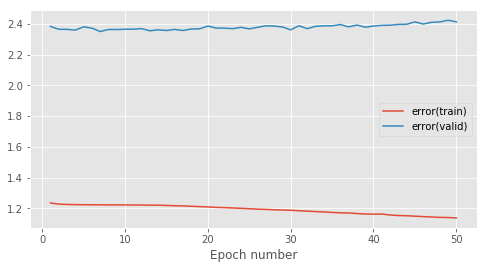

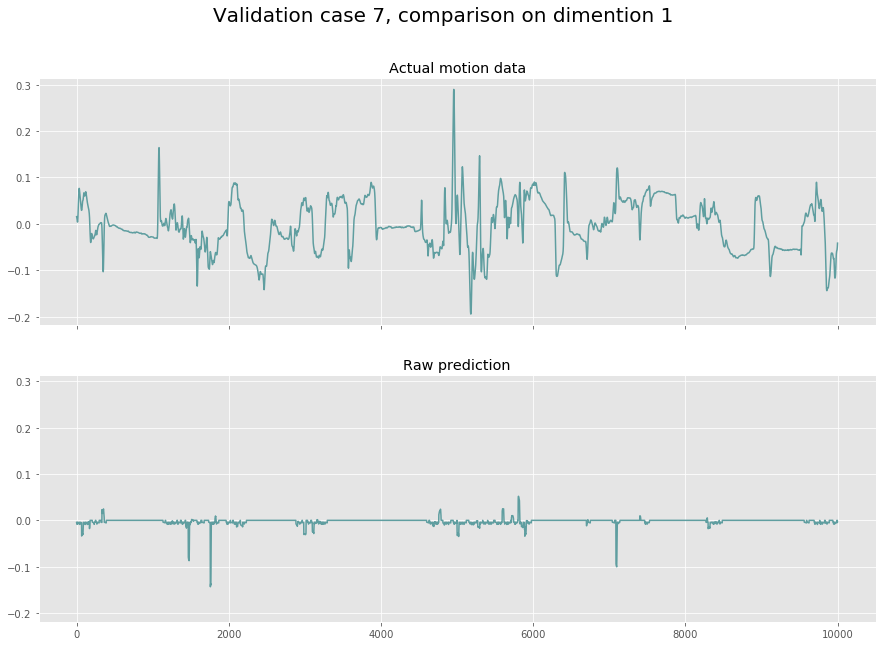

Error:    3.00216737232
Actual motion length: (29205, 6), prediction length: (28781, 6)


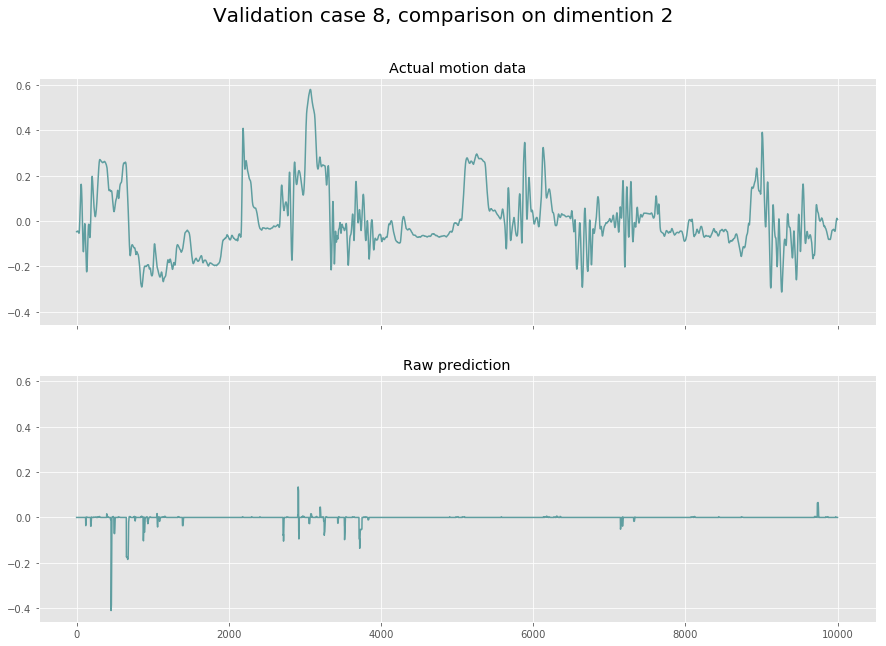

Error:    0.564785338269
Actual motion length: (32013, 6), prediction length: (31634, 6)


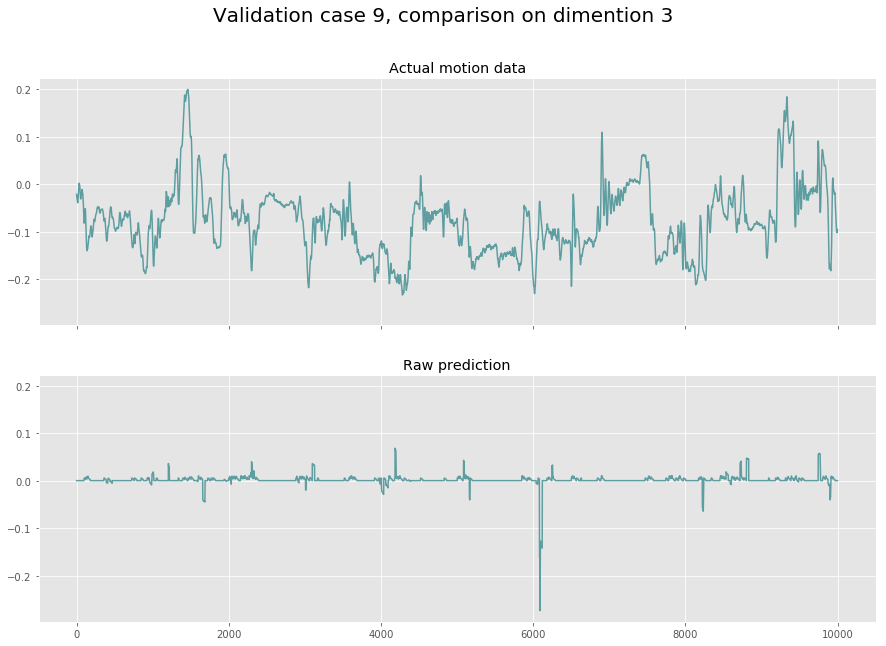

Error:    0.305127684655
Actual motion length: (30751, 6), prediction length: (30636, 6)


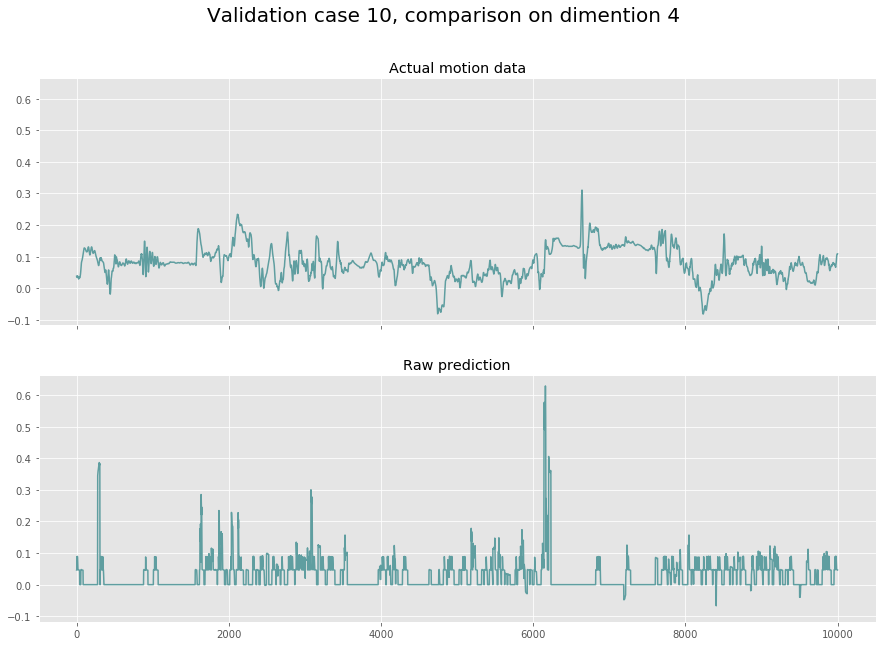

Error:    1.1262573821
Actual motion length: (31759, 6), prediction length: (31671, 6)


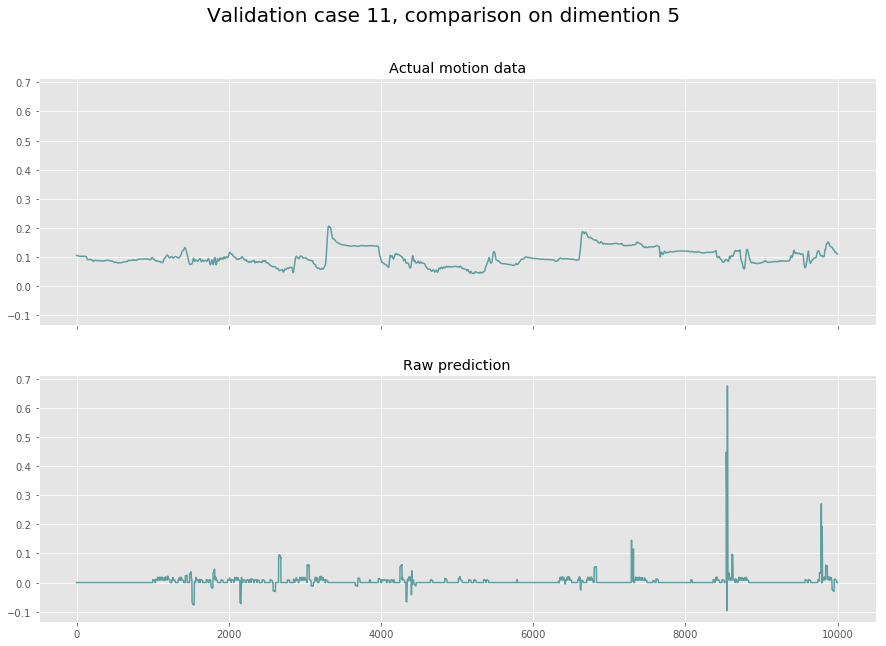

Error:    3.44221516511
Actual motion length: (30992, 6), prediction length: (30892, 6)


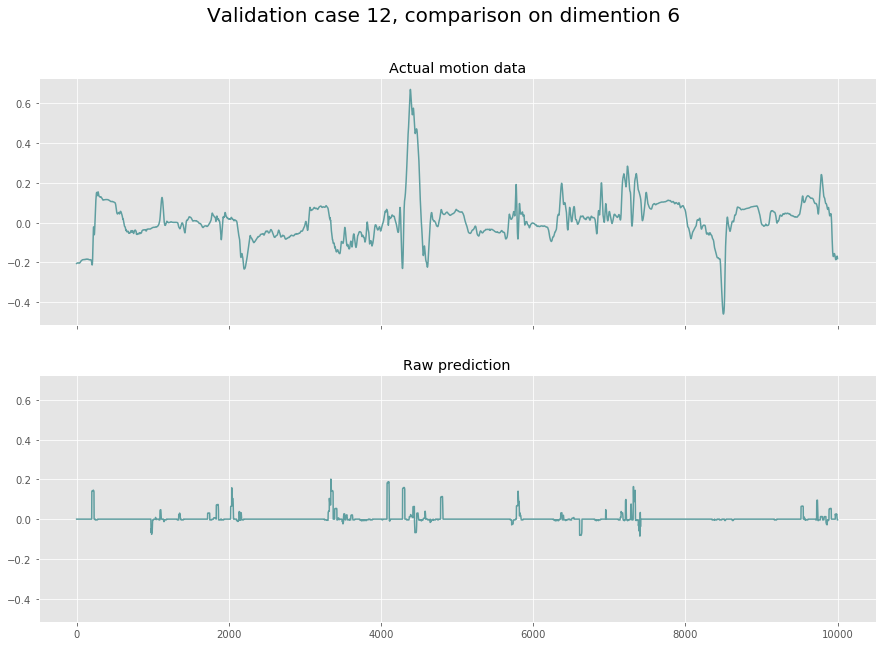

Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 239.26it/s]Epoch 1: 1.0s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.38e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 234.98it/s]Epoch 2: 1.0s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 234.59it/s]Epoch 3: 1.0s to complete
    error(train)=1.23e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 173.04it/s]Epoch 4: 1.3s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 223.35it/s]Epoch 5: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.51e-01, error(valid)=2.37e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 202.02it/s]Epoch 6: 1.1s to co

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 219.91it/s]Epoch 9: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 210.63it/s]Epoch 10: 1.1s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 240.37it/s]Epoch 11: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 185.58it/s]
Epoch 12: 1.2s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 257.77it/s]
Epoch 13: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.16e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 247.81it/s]Epoch 14: 0.9

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 224.17it/s]Epoch 18: 1.0s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.36e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 265.06it/s]Epoch 19: 0.9s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.15e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 273.32it/s]
Epoch 20: 0.8s to complete
    error(train)=1.22e+00, acc(train)=3.52e-01, error(valid)=2.37e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 231.98it/s]Epoch 21: 1.0s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 189.38it/s]Epoch 22: 1.2s to complete
    error(train)=1.21e+00, acc(train)=3.53e-01, error(valid)=2.37e+00, acc(valid)=6.14e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 248.82it/s]Epoch 23: 0.9

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 203.46it/s]Epoch 27: 1.1s to complete
    error(train)=1.20e+00, acc(train)=3.54e-01, error(valid)=2.37e+00, acc(valid)=6.11e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 208.12it/s]Epoch 28: 1.1s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.38e+00, acc(valid)=6.09e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 226.43it/s]Epoch 29: 1.0s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.37e+00, acc(valid)=6.13e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 213.99it/s]Epoch 30: 1.1s to complete
    error(train)=1.20e+00, acc(train)=3.56e-01, error(valid)=2.38e+00, acc(valid)=6.10e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 217.16it/s]Epoch 31: 1.1s to complete
    error(train)=1.20e+00, acc(train)=3.55e-01, error(valid)=2.38e+00, acc(valid)=6.09e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 161.33it/s]Epoch 32: 1.4s

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 181.17it/s]Epoch 35: 1.3s to complete
    error(train)=1.19e+00, acc(train)=3.59e-01, error(valid)=2.39e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 174.44it/s]Epoch 36: 1.3s to complete
    error(train)=1.18e+00, acc(train)=3.59e-01, error(valid)=2.40e+00, acc(valid)=6.06e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 174.73it/s]Epoch 37: 1.3s to complete
    error(train)=1.18e+00, acc(train)=3.60e-01, error(valid)=2.39e+00, acc(valid)=6.08e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 165.88it/s]Epoch 38: 1.4s to complete
    error(train)=1.18e+00, acc(train)=3.61e-01, error(valid)=2.39e+00, acc(valid)=6.04e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 196.37it/s]Epoch 39: 1.2s to complete
    error(train)=1.18e+00, acc(train)=3.62e-01, error(valid)=2.39e+00, acc(valid)=6.07e-01
Epoch Progress: 100%|██████████| 228/228 [00:00<00:00, 233.05it/s]Epoch 40: 1.0s

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 166.80it/s]Epoch 42: 1.4s to complete
    error(train)=1.17e+00, acc(train)=3.63e-01, error(valid)=2.40e+00, acc(valid)=6.02e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 172.54it/s]Epoch 43: 1.3s to complete
    error(train)=1.16e+00, acc(train)=3.63e-01, error(valid)=2.40e+00, acc(valid)=6.02e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 170.59it/s]Epoch 44: 1.3s to complete
    error(train)=1.16e+00, acc(train)=3.64e-01, error(valid)=2.40e+00, acc(valid)=6.02e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 176.59it/s]Epoch 45: 1.3s to complete
    error(train)=1.16e+00, acc(train)=3.65e-01, error(valid)=2.41e+00, acc(valid)=5.97e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 206.53it/s]Epoch 46: 1.1s to complete
    error(train)=1.16e+00, acc(train)=3.64e-01, error(valid)=2.41e+00, acc(valid)=6.00e-01
Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 221.49it/s]Epoch 47: 1.0s

Epoch Progress: 100%|██████████| 228/228 [00:01<00:00, 144.70it/s]Epoch 50: 1.6s to complete
    error(train)=1.15e+00, acc(train)=3.68e-01, error(valid)=2.42e+00, acc(valid)=5.96e-01
Experiment Progress: 100%|██████████| 50/50 [01:13<00:00,  1.74s/it]


Error:    0.813747134478
Actual motion length: (33656, 6), prediction length: (32972, 6)


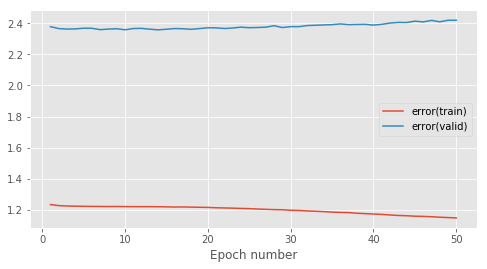

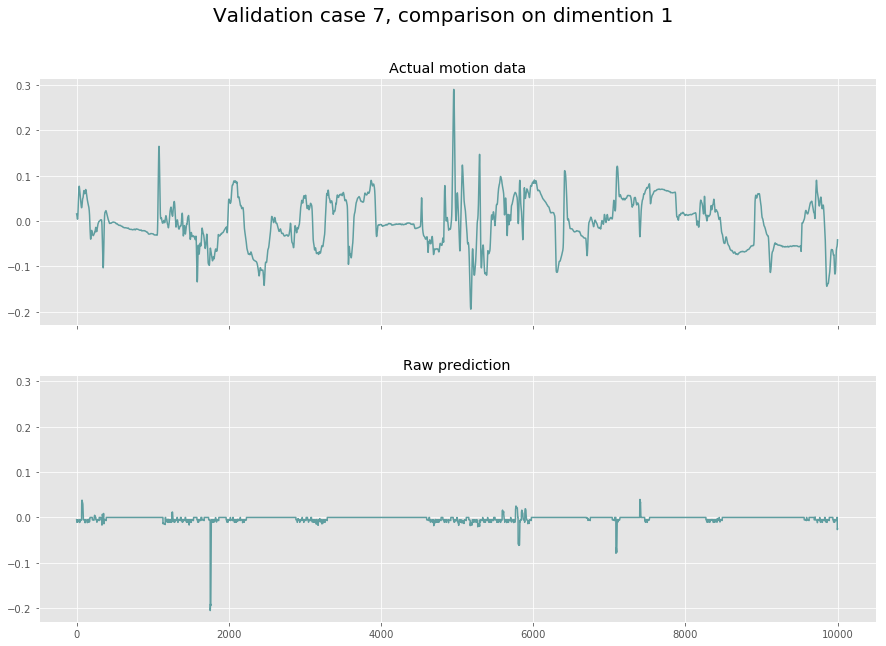

Error:    2.93027106017
Actual motion length: (29205, 6), prediction length: (28781, 6)


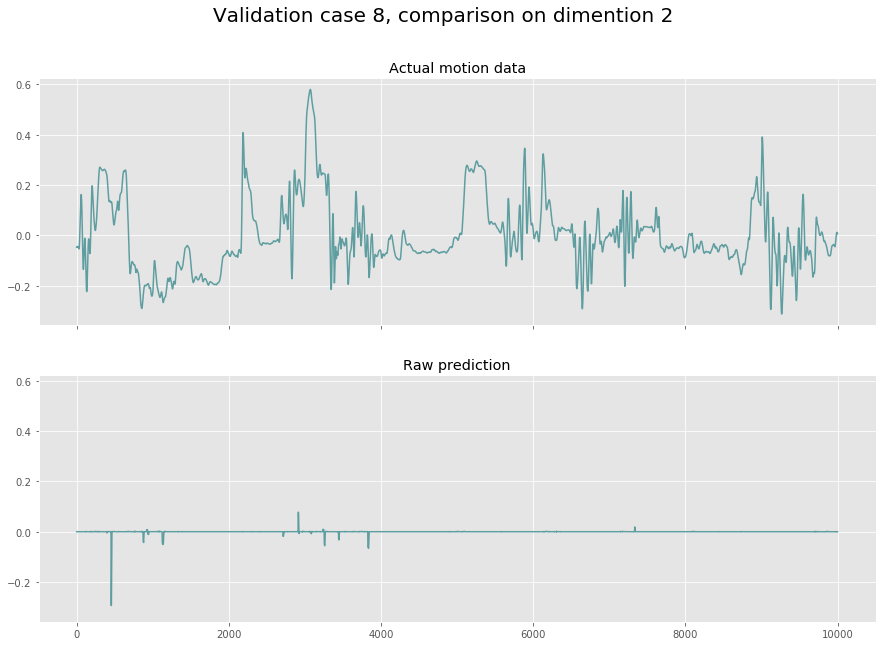

Error:    0.567692319369
Actual motion length: (32013, 6), prediction length: (31634, 6)


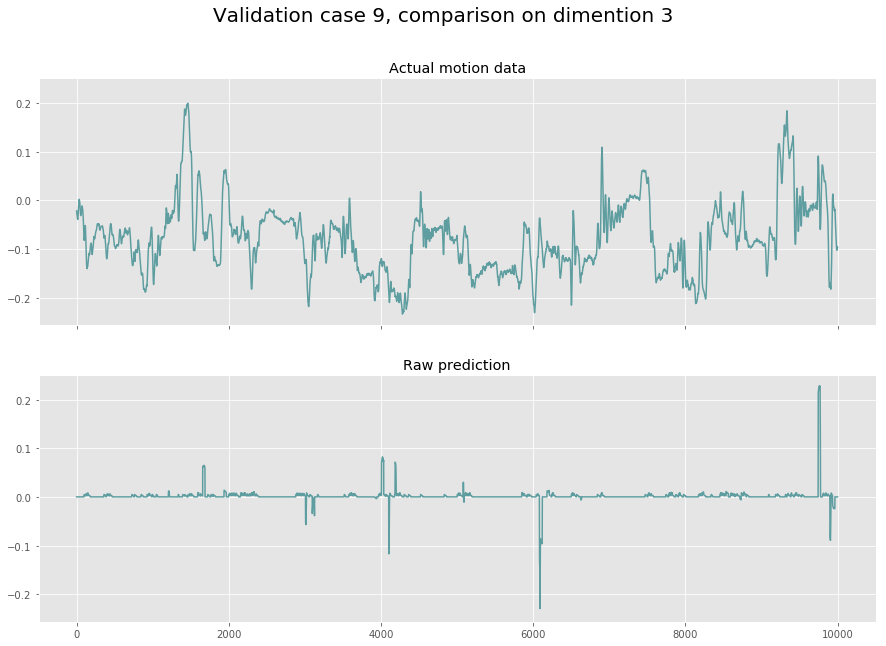

Error:    0.301036065408
Actual motion length: (30751, 6), prediction length: (30636, 6)


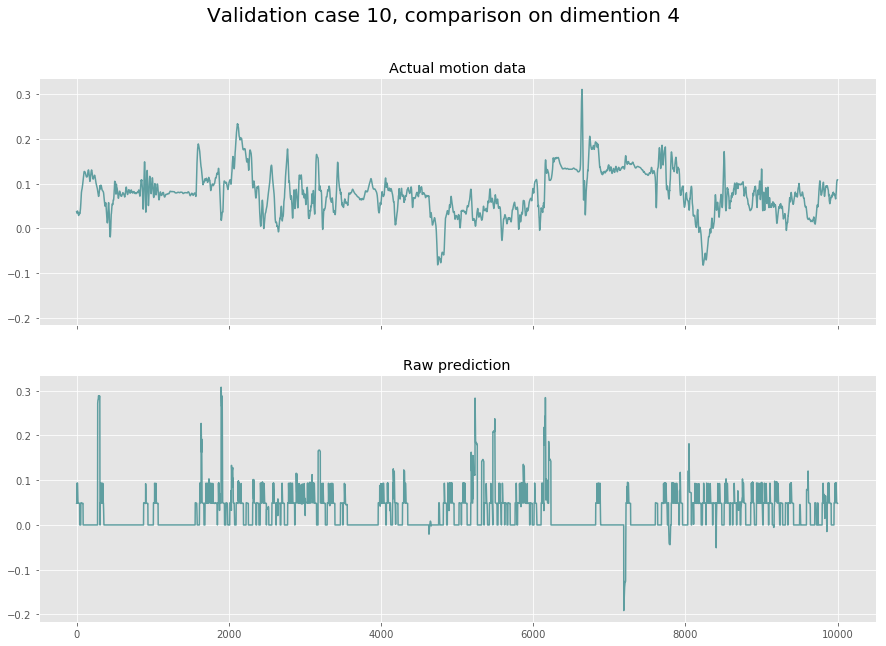

Error:    1.11711697452
Actual motion length: (31759, 6), prediction length: (31671, 6)


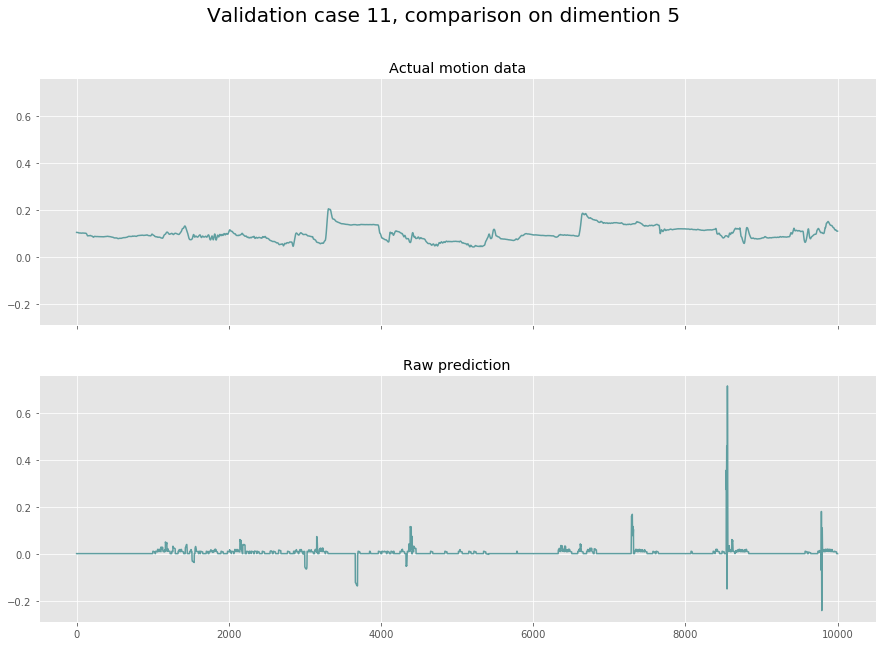

Error:    3.47212581733
Actual motion length: (30992, 6), prediction length: (30892, 6)


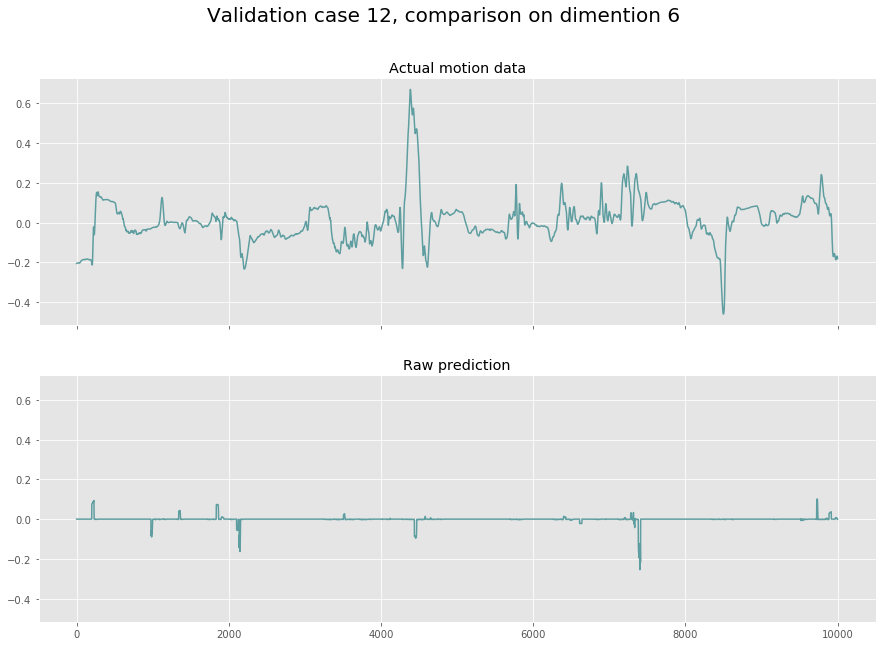

In [96]:
batch_sizes = [20, 40, 60, 80, 100]
# predictions length will be 5*6: 5 diff batch sizes and 6 validation cases
predictions = []
stats = []

for batch_size in batch_sizes:

    init_scale = 0.01  
    learning_rate = 0.001  
    num_epochs = 50  
    stats_interval = 1  
    hidden_dim = 200

    weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
    biases_init = ConstantInit(0.)

    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size


    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
    #     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    #     ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),
    ])

    error = SumOfSquaredDiffsError()

    learning_rule = AdamLearningRule(learning_rate=learning_rate)

    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors)

    stat, key, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stat.shape[0]) * stats_interval, 
                  stat[1:, key[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    stats.append(stat)    
    
    for i in range(7,13):
        validation_data = HMS300dDataProvider('validation{0}'.format(i), 'extro', rng=rng)
        result, evaluation = optimiser.eval_test_set(validation_data, 'validation')
        print('Error:    ' + str(evaluation['errorvalidation']))

        result_reshape = np.zeros((result[-1].shape[0], 6, 20)) # needs testig
        for j in range(result[-1].shape[0]):
            result_reshape[j] = result[-1][j].reshape(6,20)    

        time_intervals = np.loadtxt("ExtrovertRawData/Words/{}".format(i), usecols=range(4, 6), dtype="int")
        words = np.loadtxt("ExtrovertRawData/Words/{}".format(i), usecols=range(3, 4), dtype="str")

        prediction = np.zeros((6, time_intervals[-1,1] + window_size))
        counter = 0
        for index, line in enumerate(time_intervals):
            word = words[index]
            word_split = word.split('\'')

            if len(word_split) <= 1:   
                start_time = line[0]
                end_time = line[1]
                fading_point = end_time - start_time

                for k in range(6):
                    frame = np.zeros(window_size)
                    frame[0:number_of_frequency] = result_reshape[counter][k][0:number_of_frequency]
                    dct_motion = dct(frame, 3, norm="ortho")
                    faded_motion = fade_motion(dct_motion, fading_point, window_size)
                    prediction[k, start_time:start_time + window_size] += faded_motion 
                counter += 1
            else:
                start_time = line[0]
                end_time = line[1]
                mid = int((line[0] + line[1]) / 2)
                fading_point_1 = mid - start_time
                fading_point_2 = end_time - mid

                for k in range(6):
                    frame_1 = np.zeros(window_size)
                    frame_1[0:number_of_frequency] = result_reshape[counter][k][0:number_of_frequency]
                    dct_motion_1 = dct(frame_1, 3, norm="ortho")
                    faded_motion_1 = fade_motion(dct_motion_1, fading_point_1, window_size)
                    prediction[k, start_time:start_time + window_size] += faded_motion_1

                    frame_2 = np.zeros(window_size)
                    frame_2[0:number_of_frequency] = result_reshape[counter+1][k][0:number_of_frequency]
                    dct_motion_2 = dct(frame_2, 3, norm="ortho")
                    faded_motion_2 = fade_motion(dct_motion_2, fading_point_2, window_size)
                    prediction[k, mid:mid + window_size] += faded_motion_2
                counter += 2

        prediction = prediction.transpose()
        predictions.append(prediction)
        #smoothed_prediction = smooth_prediction(prediction)

        motion_data = np.loadtxt("ExtrovertRawData/Motion/{}.rov".format(i), skiprows=17, usecols=range(0, 6))

        print("Actual motion length: {}, prediction length: {}".format(motion_data.shape, prediction.shape))

        # Two subplots, the axes array is 1-d
        f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(15,10))
        axarr[0].plot(motion_data[10000:20000,i-7], color = 'cadetblue')
        axarr[0].set_title('Actual motion data')
        axarr[1].plot(prediction[10000:20000,i-7], color = 'cadetblue')
        axarr[1].set_title('Raw prediction')
    #     axarr[2].plot(smoothed_prediction[10000:20000,i-7], color = 'cadetblue')
    #     axarr[2].set_title('Smoothed prediction')

        plt.suptitle('Validation case {0}, comparison on dimention {1}'.format(i, i-6), size = 20)
        #plt.savefig('Validation case {0}, comparison on dimention {1}.pdf'.format(i, i-6))
        plt.show()

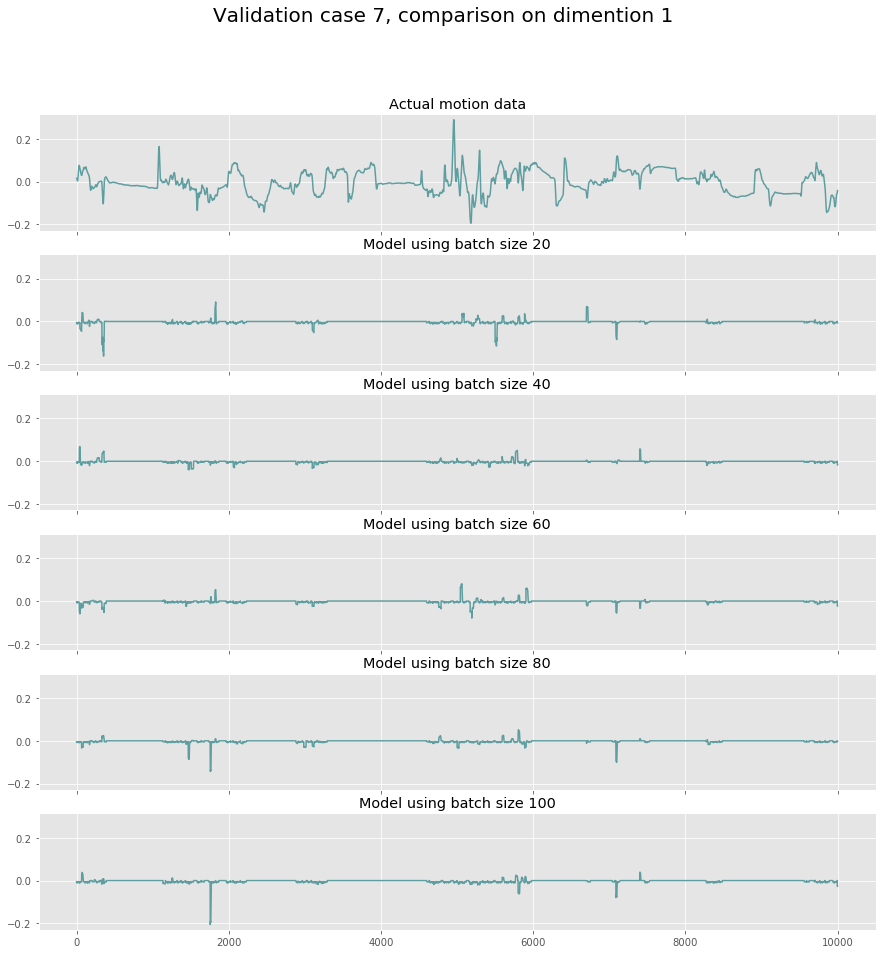

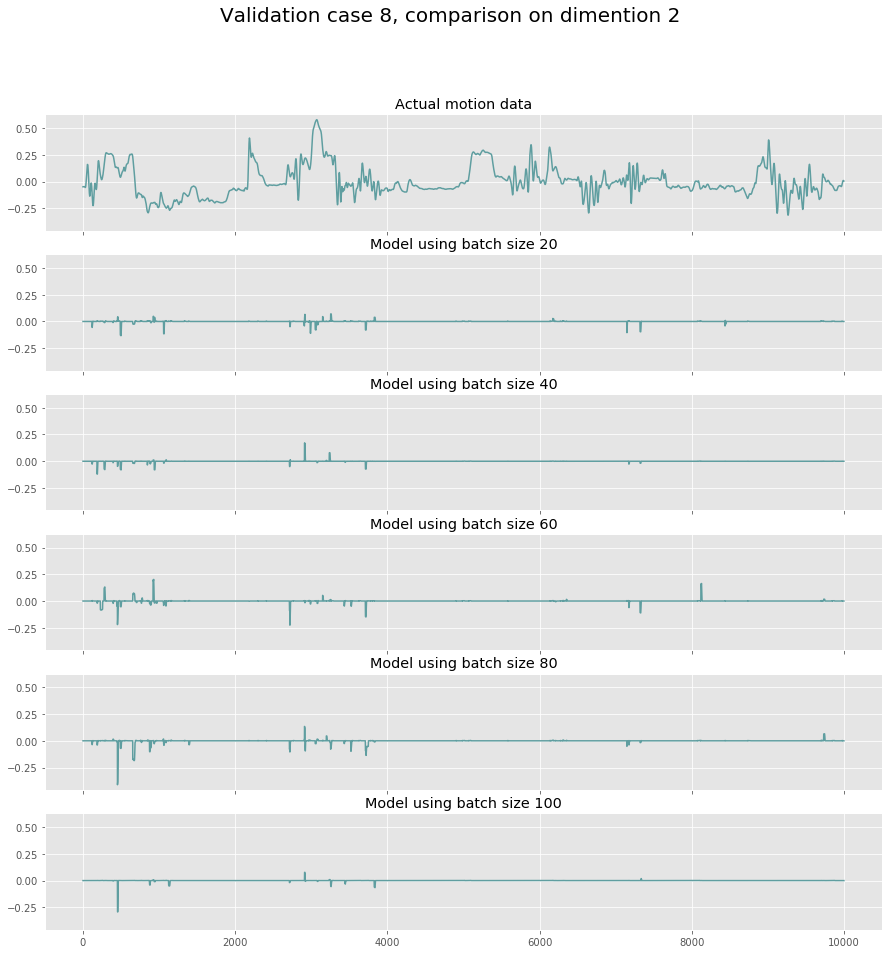

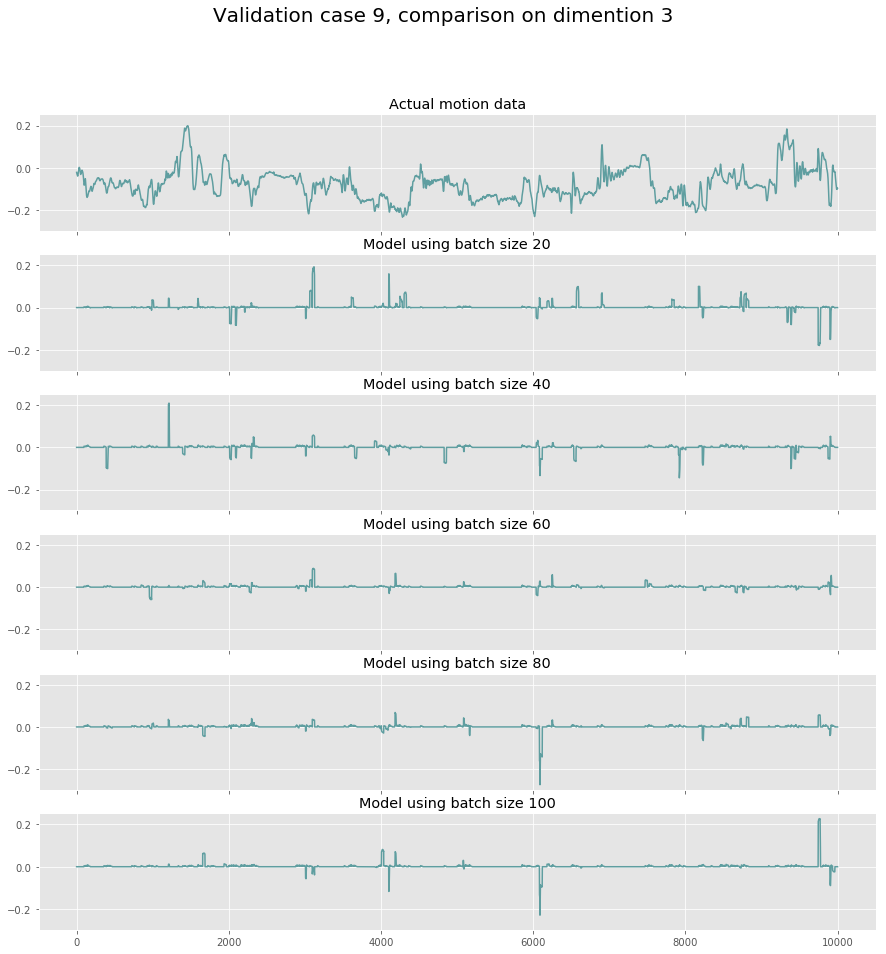

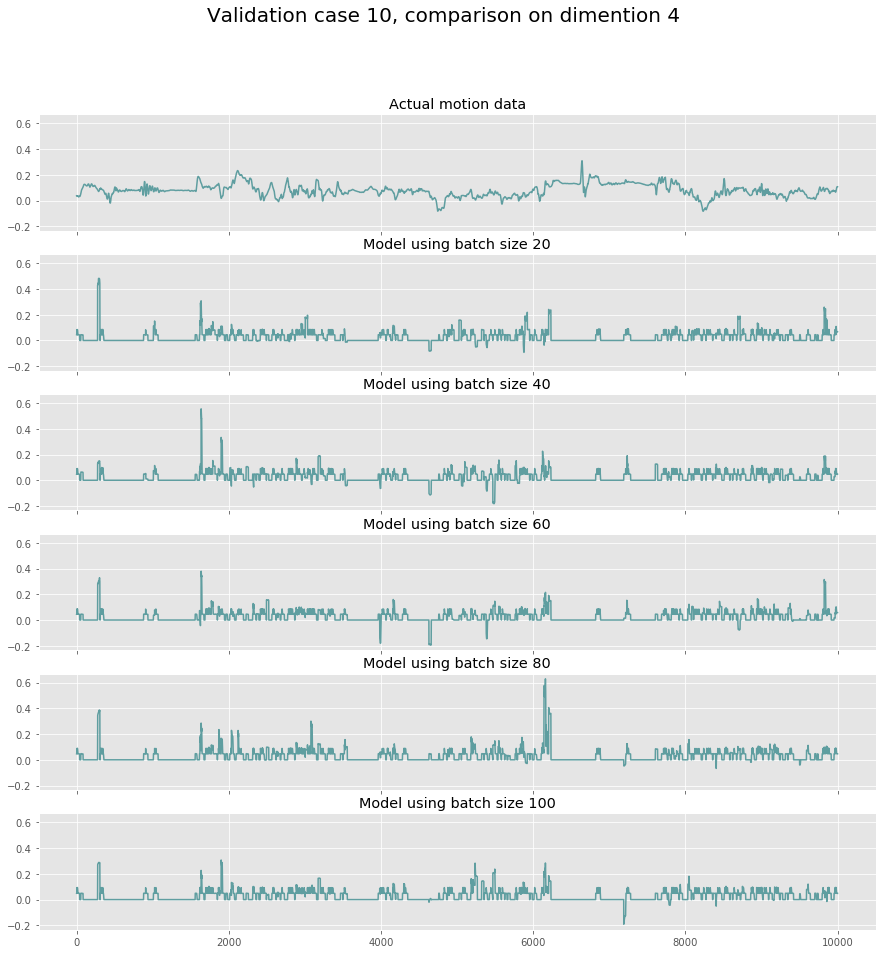

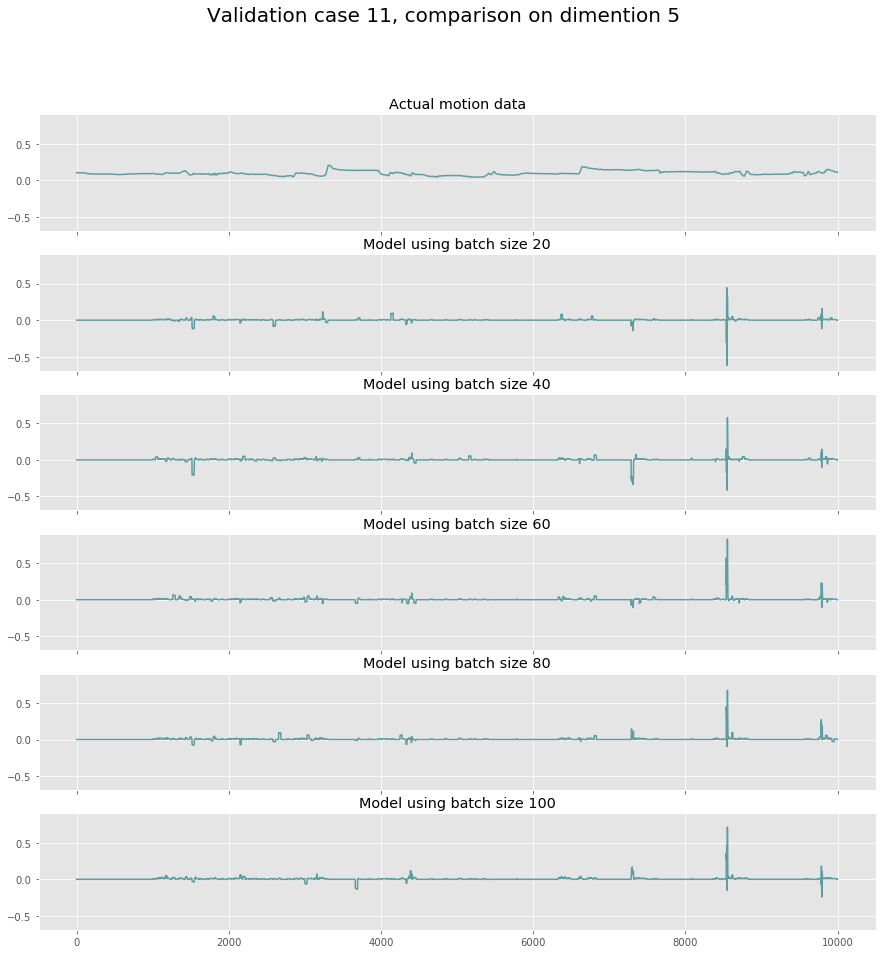

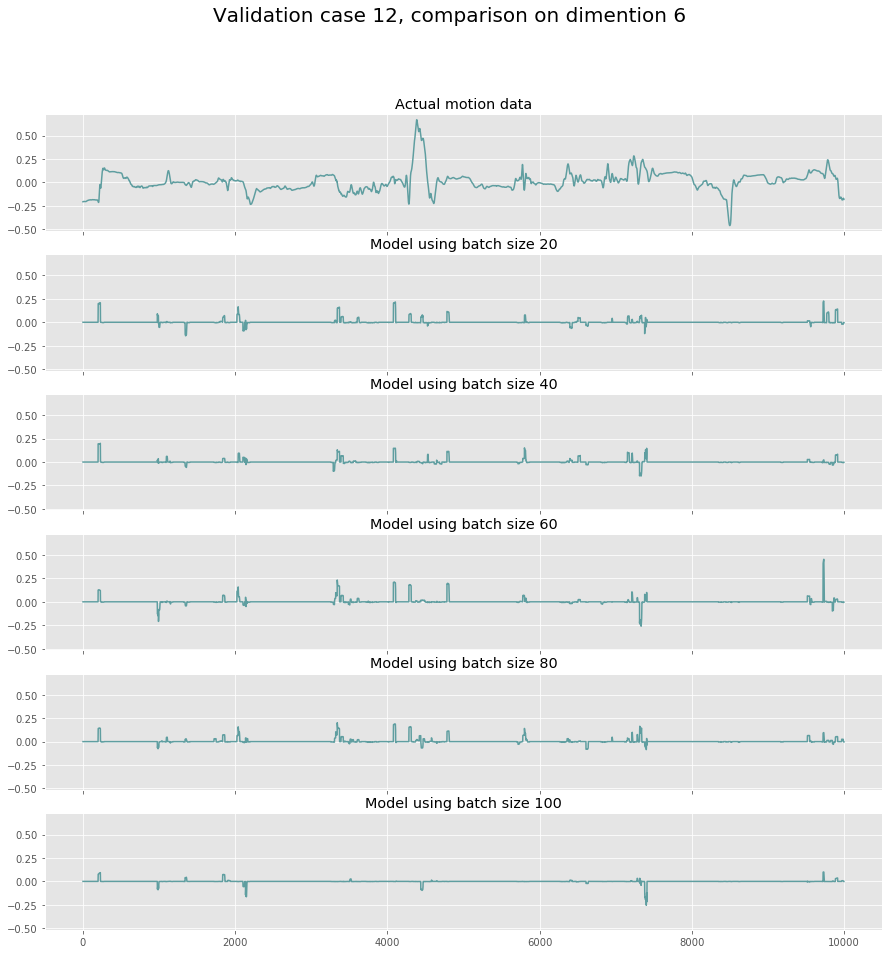

In [106]:
for i in range(7,13):
    
    predictions_column_number = i-7
    #smoothed_prediction = smooth_prediction(prediction)

    motion_data = np.loadtxt("ExtrovertRawData/Motion/{}.rov".format(i), skiprows=17, usecols=range(0, 6))

    #print("Actual motion length: {}, prediction length: {}".format(motion_data.shape, prediction.shape))

    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(6, sharex=True, sharey=True, figsize=(15,15))
    axarr[0].plot(motion_data[10000:20000,i-7], color = 'cadetblue')
    axarr[0].set_title('Actual motion data')
    axarr[1].plot(predictions[predictions_column_number][10000:20000,i-7], color = 'cadetblue')
    axarr[1].set_title('Model using batch size 20')
    axarr[2].plot(predictions[predictions_column_number+6][10000:20000,i-7], color = 'cadetblue')
    axarr[2].set_title('Model using batch size 40')
    axarr[3].plot(predictions[predictions_column_number+12][10000:20000,i-7], color = 'cadetblue')
    axarr[3].set_title('Model using batch size 60')
    axarr[4].plot(predictions[predictions_column_number+18][10000:20000,i-7], color = 'cadetblue')
    axarr[4].set_title('Model using batch size 80')
    axarr[5].plot(predictions[predictions_column_number+24][10000:20000,i-7], color = 'cadetblue')
    axarr[5].set_title('Model using batch size 100')

    plt.suptitle('Validation case {0}, comparison on dimention {1}'.format(i, i-6), size = 20)
    plt.savefig('Validation case {0}, comparison on dimention {1}.pdf'.format(i, i-6))
    plt.show()    

Motion shape: (6, 30636), prediction shape: (6, 30636)
CC of dimension 0  is  -0.0553584160756
CC of dimension 1  is  -0.0104978651665
CC of dimension 2  is  -0.054602073009
CC of dimension 3  is  -0.0917910224497
CC of dimension 4  is  -0.0404822550328
CC of dimension 5  is  -0.00600464273042


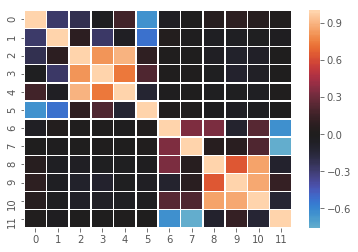

In [113]:
motion_data = np.loadtxt("ExtrovertRawData/Motion/10.rov", skiprows=17, usecols=range(0, 6))

motion_transpose = np.array(motion_data.transpose())[:,:30636]
prediction_transpose = np.array(predictions[3].transpose())

print("Motion shape: {}, prediction shape: {}".format(motion_transpose.shape, prediction_transpose.shape))
pearson_correlation_coefficient = np.corrcoef(motion_transpose, prediction_transpose)
plot = sns.heatmap(pearson_correlation_coefficient, center=0, linewidths=.5)
fig = plot.get_figure()
fig.savefig("Heatmap Wiki")
for i in range(6):
    print("CC of dimension {}".format(i), " is ", pearson_correlation_coefficient[i,i+6])

In [ ]:
## Produce test cases

In [ ]:
# Loop over 1-6 test cases

window_size = 100
for i in range(1,7):
    test_data = HMSDataProvider('test{0}'.format(i), 'intro', rng=rng)
    result, evaluation = optimiser.eval_test_set(test_data, 'test')
    print('Error:    ' + str(evaluation['errortest']))

    result_reshape = np.zeros((result[-1].shape[0], 6, 10)) # needs testig
    for j in range(result[-1].shape[0]):
        result_reshape[j] = result[-1][j].reshape(6,10)    
    
    time_intervals = np.loadtxt("IntrovertRawData/Words/{0}".format(i), usecols=range(4, 6), dtype="int")
    words = np.loadtxt("IntrovertRawData/Words/{0}".format(i), usecols=range(3, 4), dtype="str")
    
    prediction = np.zeros((6, time_intervals[-1,1] + window_size))
    counter = 0
    for index, line in enumerate(time_intervals):
        word = words[index]
        word_split = word.split('\'')
        
        if len(word_split) <= 1:   
            start_time = line[0]
            end_time = line[1]
            fading_point = end_time - start_time
            
            for k in range(6):
                frame = np.zeros(window_size)
                frame[0:10] = result_reshape[counter][k]
                dct_motion = dct(frame, 3, norm="ortho")
                faded_motion = fade_motion(dct_motion, fading_point, window_size)
                prediction[k, start_time:start_time + window_size] += faded_motion 
            counter += 1
        else:
            start_time = line[0]
            end_time = line[1]
            mid = int((line[0] + line[1]) / 2)
            fading_point_1 = mid - start_time
            fading_point_2 = end_time - mid
            
            for k in range(6):
                frame_1 = np.zeros(window_size)
                frame_1[0:10] = result_reshape[counter][k]
                dct_motion_1 = dct(frame_1, 3, norm="ortho")
                faded_motion_1 = fade_motion(dct_motion_1, fading_point_1, window_size)
                prediction[k, start_time:start_time + window_size] += faded_motion_1
                
                frame_2 = np.zeros(window_size)
                frame_2[0:10] = result_reshape[counter+1][k]
                dct_motion_2 = dct(frame_2, 3, norm="ortho")
                faded_motion_2 = fade_motion(dct_motion_2, fading_point_2, window_size)
                prediction[k, mid:mid + window_size] += faded_motion_2
            counter += 2
        
    prediction = prediction.transpose()
    smoothed_prediction = smooth_prediction(prediction)
    
    # If trained on intro data
    # np.savetxt('Predictions/TrainedOnIntroData/prediction{0}.txt'.format(i), prediction, fmt="%.7f")

    np.savetxt('Predictions/intro_{0}.txt'.format(i), prediction, fmt="%.7f")
    np.savetxt('Predictions/intro_smooth_{0}.txt'.format(i), smoothed_prediction, fmt="%.7f")

    
    motion_data = np.loadtxt("IntrovertRawData/Motion/1.rov".format(i), skiprows=17, usecols=range(0, 6))

    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(3, sharex=True, figsize=(15,10))
    axarr[0].plot(motion_data[:,i-1], color = 'cadetblue')
    axarr[0].set_title('Actual motion data')
    axarr[1].plot(prediction[:,i-1], color = 'cadetblue')
    axarr[1].set_title('Raw prediction')
    axarr[2].plot(smoothed_prediction[:,i-1], color = 'cadetblue')
    axarr[2].set_title('Smoothed prediction')
    
    plt.suptitle('Test case {0}, comparison on dimention {1}'.format(i, i), size = 20)
    plt.savefig('Predictions/Test case {0}, comparison on dimention {1}.pdf'.format(i, i))
    plt.show()